# Проект: Обучение с учителем: качество модели

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Как решать задачу
Продумывать подход к решению этой задачи вам не придётся — руководитель отдела его уже сформировал:
Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
Нужно собрать данные по клиентам по следующим группам:
* Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
* Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
* Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
* Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

**Задачи:**
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

# Утилиты

## Импорты

In [1]:
!pip install numpy==1.22
!pip install -U scikit-learn
!pip install matplotlib==3.5
!pip install phik
!pip install shap

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


RANDOM_STATE = 42
TEST_SIZE = 0.2

## Вспомогательные функции

### Общая информация о таблице

In [3]:
def data_info(
        df: pd.DataFrame
) -> None:
    '''
    Функция принимает на вход pandas.DataFrame и выводит первые 5 строк, 
    основную информацию о данных по столбцам и статистическое описание 
    количественных признаков 
    '''
    print('\n' + '-' * 5 + 'Пример данных' + '-' * 5 + '\n')
    display(df.head())
    print('\n' + '-' * 5 + 'Информация о данных' + '-' * 5 + '\n')
    display(df.info())
    print('\n' + '-' * 5 + 'Статистическое опиасние данных' + '-' * 5 + '\n')
    display(df.describe())

### Построение графиков для статистического анализа

In [4]:
def plotting_stat_graphs(
        data,
        target=None,
        discrete_threshold=20
) -> None:
    '''
    На вход подается pandas.DataFrame или pandas.Series
    Строятся графики для статистического анализа:
        Для численных столбцов строится гистограмма и ящик с усами, 
        Если данные дискретные - строится как и для категориальных
        барплот и круговая диаграмма
    Если указан target, то гистограммы строятся с учетом разделения по таргетам
    '''
    if target and target not in data.columns:
        print('Неверное значение target')
        return
    if isinstance(data, pd.DataFrame):
        numeric_cols = pd.DataFrame(
            data.nunique(),
            columns=['counts']
        ).query('counts > @discrete_threshold').index
        non_numeric_cols = pd.DataFrame(
            data.nunique(),
            columns=['counts']
        ).query('counts <= @discrete_threshold').index

        for col in numeric_cols:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            if not target:
                sns.histplot(data, kde=True, bins=50, x=col)
            else:
                sns.histplot(
                    data, 
                    kde=True,
                    stat='density', 
                    common_norm=False,
                    hue=target, 
                    bins=50, 
                    x=col
                )
            plt.title(f'Гистограмма для {col}')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(x=data[col])
            plt.title(f'Боксплот для {col}')
            
            plt.tight_layout()
            plt.show()
    
        for col in non_numeric_cols:
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            
            if not target:
                sns.countplot(
                    y=col, 
                    data=data, 
                    order=data[col].value_counts().index
                    )
            else:
                sns.countplot(
                    y=col, 
                    data=data,
                    hue=target,
                    order=data[col].value_counts().index
                    )
            plt.title(f'Барплот для {col}')

            plt.subplot(1, 2, 2)
            plt.pie(
                data[col].value_counts(),
                labels=data[col].value_counts().index,
                autopct='%1.2f%%',
                startangle=90
            )
            plt.title(f'Распределение {data[col].shape[0]} значений {col}')

            plt.tight_layout()
            plt.show()

    elif isinstance(data, pd.Series):
        if is_numeric_dtype(data) and data.nunique() > discrete_threshold:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            if not target:
                sns.histplot(data, kde=True, bins=50, x=col)
            else:
                sns.histplot(data, kde=True, hue=target, bins=50, x=col)
            plt.title(f'Гистограмма для {data.name}')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(x=data)
            plt.title(f'Боксплот для {data.name}')
            
            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            if not target:
                sns.countplot(x=data, order=data.value_counts().index)
            else:
                sns.countplot(x=data, hue=target, order=data.value_counts().index)
            plt.title(f'Барплот для {data.name}')

            plt.subplot(1, 2, 2)
            plt.pie(
                data.value_counts(),
                labels=data.value_counts().index,
                autopct='%1.2f%%',
                startangle=90
            )
            plt.title(f'Распределение {data.shape[0]} значений {data.name}')

            plt.tight_layout()
            plt.show()

    else:
        print('Неверный формат входных данных')
        

### Тест Шапиро-Уилка

In [5]:
def shapiro_results(
        data: pd.DataFrame
) -> None:
    '''
    На вход подается pandas.DataFrame
    На выходе выводятся результаты статистического теста Шапиро-Уилка
    для каждого численного столбца
    '''
    for col in data.select_dtypes(include=['number']).columns:
        if col == 'id':
            continue
        shapiro = st.shapiro(data[col])
        print(f'''Тест Шапиро-Уилка для {col}: p-value = {shapiro.pvalue}\n''')

## Результаты подбора гиперпараметров

In [6]:
def cv_results(searcher) -> None:
    aim_cols = [
        'mean_test_score',
        'param_models',
        'param_preprocessor__num',
        'param_models__kernel',
        'param_models__gamma',
        'param_models__degree',
        'param_models__C',
        'param_models__min_samples_split',
        'param_models__max_features',
        'param_models__max_depth',
        'params'
    ]
    display(
    pd.DataFrame(searcher.cv_results_)
    .sort_values(by='mean_test_score', ascending=False)
    .reset_index(drop=True)
    .loc[:, [col for col in searcher.cv_results_.keys() if col in aim_cols]]
)

# Загрузка данных

На этом этапе загрузим полученные таблицы, познакомимся с представленными данными, их описанием

Загрузим три таблицы из файлов `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`. В названиях переменных сохраним название файлов

In [7]:
try:  
    market_file = pd.read_csv('./Data/market_file.csv')
    market_money = pd.read_csv('./Data/market_money.csv')
    market_time = pd.read_csv('./Data/market_time.csv')
    money = pd.read_csv('./Data/money.csv', sep=';', decimal=',')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

## Описание данных

### market_file

In [8]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Описание, предоставленное заказчиком:

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

### market_money

In [9]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Описание, предоставленное заказчиком:

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

### market_time

In [10]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Описание, предоставленное заказчиком:

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

### money

In [11]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Описание, предоставленное заказчиком:

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

## Промежуточные выводы:

Полученные данные содержат информацию о покупателях, их продуктовом поведении, приносимой ими выручке, об их взаимодействии с сервисами магазина. 

Описание, полученное от заказчика корректно

В данных `money.csv` в качестве разделителя испольуется ";", а в записи десятичной дроби - ","

# Предобработка данных

 Посмотрим на структуру данных

In [12]:
data_info(market_file)


-----Пример данных-----



,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



-----Информация о данных-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11

None


-----Статистическое опиасние данных-----



,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


В `market_file` явных проблем не обнаружено. В данных нет явных пустых значений, типизация корректна

In [13]:
data_info(market_money)


-----Пример данных-----



,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



-----Информация о данных-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


-----Статистическое опиасние данных-----



,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


В `market_money` предварительно проблем также не выявлено

In [14]:
data_info(market_time)


-----Пример данных-----



,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



-----Информация о данных-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


-----Статистическое опиасние данных-----



,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


В `market_money` предварительно проблем также нет

In [15]:
data_info(money)


-----Пример данных-----



,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



-----Информация о данных-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


-----Статистическое опиасние данных-----



,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


В `money` были отличный способ разделения колонок csv. После корректировки значения также оказались в норме

## Переименование столбцов

В полученных данных названия столбцов имеют стилистические ошибки. Переведем названия в подходящий формат, переписав в snake_case

In [16]:
new_colnames = {
    'id': 'id',  
    'Покупательская активность': 'customer_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'allow_notifications',
    'Маркет_актив_6_мес': 'marketing_activity_6_months',
    'Маркет_актив_тек_мес': 'marketing_activity_current_month',
    'Длительность': 'duration',
    'Акционные_покупки': 'promo_purchases',
    'Популярная_категория': 'popular_category',
    'Средний_просмотр_категорий_за_визит': 'avg_categories_viewed_per_visit',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_products_qty_quarter',
    'Ошибка_сервиса': 'service_error',
    'Страниц_за_визит': 'pages_per_visit',
    'Период': 'period',  
    'Выручка': 'revenue',
    'минут': 'minutes',
    'Прибыль': 'profit'
}

market_file = market_file.rename(columns=new_colnames)
market_money = market_money.rename(columns=new_colnames)
market_time = market_time.rename(columns=new_colnames)
money = money.rename(columns=new_colnames)

## Пропуски

Еще раз убедимся в том, что в данных нет пропусков

In [17]:
market_file.isna().sum()

id                                  0
customer_activity                   0
service_type                        0
allow_notifications                 0
marketing_activity_6_months         0
marketing_activity_current_month    0
duration                            0
promo_purchases                     0
popular_category                    0
avg_categories_viewed_per_visit     0
unpaid_products_qty_quarter         0
service_error                       0
pages_per_visit                     0
dtype: int64

In [18]:
market_money.isna().sum()

id         0
period     0
revenue    0
dtype: int64

In [19]:
market_time.isna().sum()

id         0
period     0
minutes    0
dtype: int64

In [20]:
money.isna().sum()

id        0
profit    0
dtype: int64

Пропусков нет, можем работать дальше

## Дубликаты

Сначала посмотрим на явные дубликаты в данных

In [21]:
market_file.duplicated().sum()

0

In [22]:
market_money.duplicated().sum()

0

In [23]:
market_time.duplicated().sum()

0

In [24]:
money.duplicated().sum()

0

Явных дубликатов нет. Посотрим есть ли неявные дубликаты

In [25]:
tables = [market_file, market_time, market_money, money]

for table in tables:
    display(table.head(1))
    for col in table.select_dtypes(include=['object']).columns:
        print('\n', col, '\n')
        display(table[col].value_counts())

,id,customer_activity,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5



 customer_activity 



Прежний уровень    802
Снизилась          498
Name: customer_activity, dtype: int64


 service_type 



стандарт     914
премиум      376
стандартт     10
Name: service_type, dtype: int64


 allow_notifications 



да     962
нет    338
Name: allow_notifications, dtype: int64


 popular_category 



Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: popular_category, dtype: int64

,id,period,minutes
0,215348,текущий_месяц,14



 period 



текущий_месяц       1300
предыдцщий_месяц    1300
Name: period, dtype: int64

,id,period,revenue
0,215348,препредыдущий_месяц,0.0



 period 



текущий_месяц          1300
предыдущий_месяц       1300
препредыдущий_месяц    1300
Name: period, dtype: int64

,id,profit
0,215348,0.98


В таблице `market_file` в столбце `service_type` есть две записи - 'стандартт' и 'стандарт'. Заменим все на 'стандарт'

In [26]:
(
    market_file
    .loc[market_file['service_type'] == 'стандартт', 'service_type']
) = 'стандарт'

In [27]:
market_file['service_type'].value_counts()

стандарт    924
премиум     376
Name: service_type, dtype: int64

И еще раз проверим явные дубликаты в этой таблице

In [28]:
market_file.duplicated().sum()

0

## Промежуточный вывод

Корректность типизации была проверена на предыдущем шаге. 

Пропусков в данных нет, явные дубликаты отсутствуют. 

В столбце `service_type` таблицы `market_file` была ошибка в записи: 'стандартт' заменили на 'стандарт' 

# Исследовательский анализ данных

## Распределение признаков в данных

### market_file

In [29]:
market_file.columns

Index(['id', 'customer_activity', 'service_type', 'allow_notifications',
       'marketing_activity_6_months', 'marketing_activity_current_month',
       'duration', 'promo_purchases', 'popular_category',
       'avg_categories_viewed_per_visit', 'unpaid_products_qty_quarter',
       'service_error', 'pages_per_visit'],
      dtype='object')

In [30]:
market_file['avg_categories_viewed_per_visit'].nunique()

6

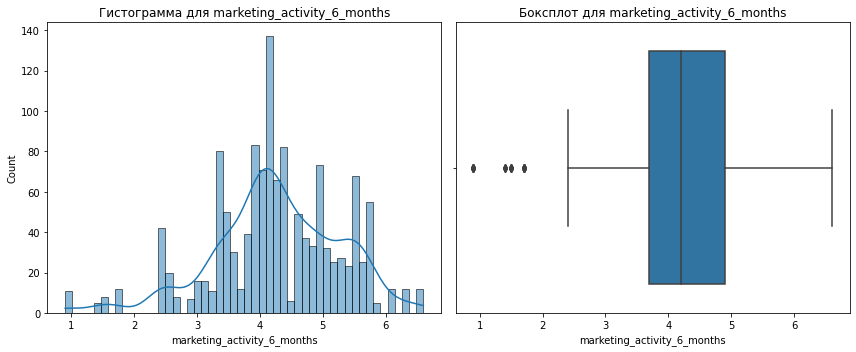

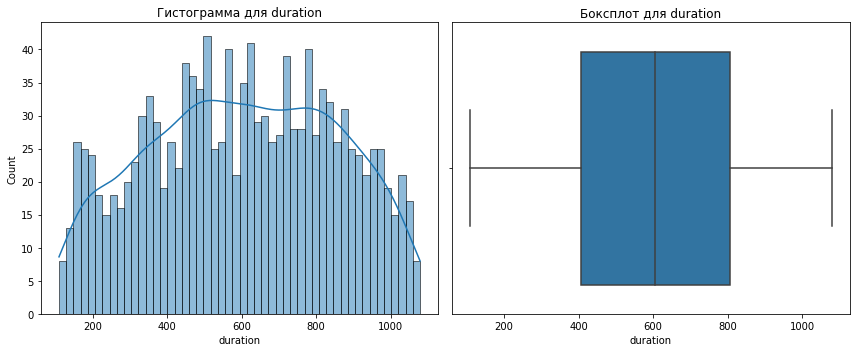

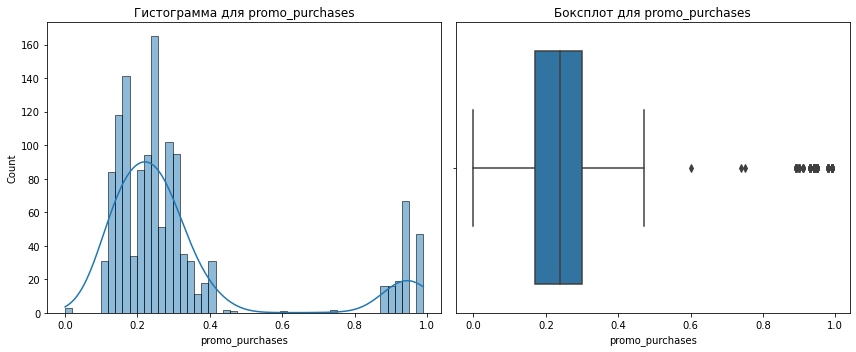

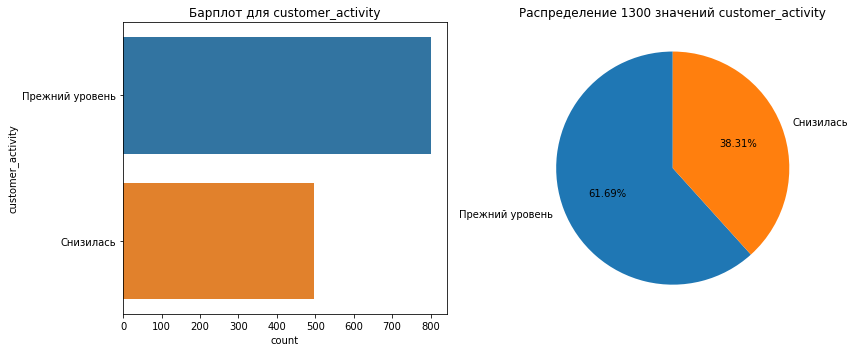

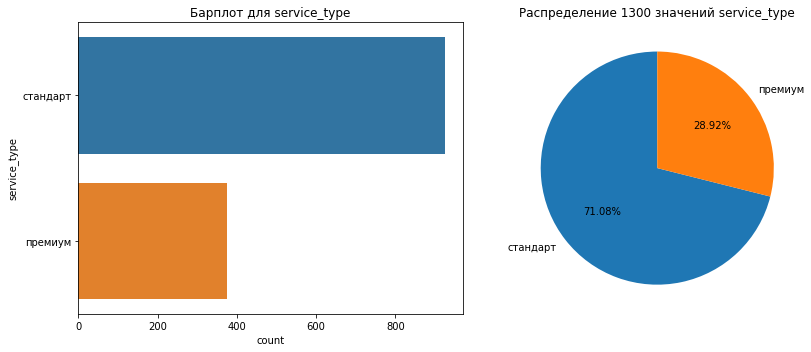

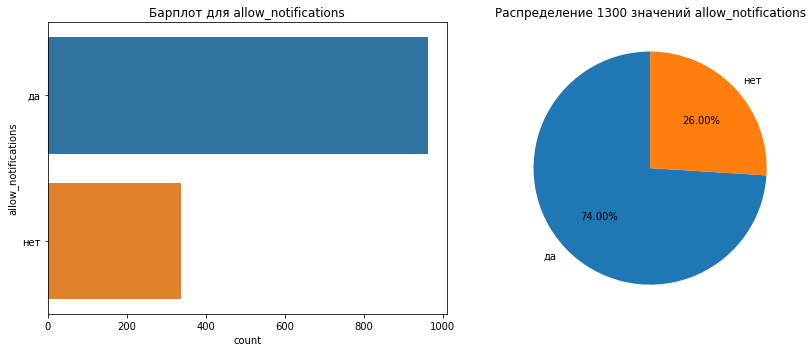

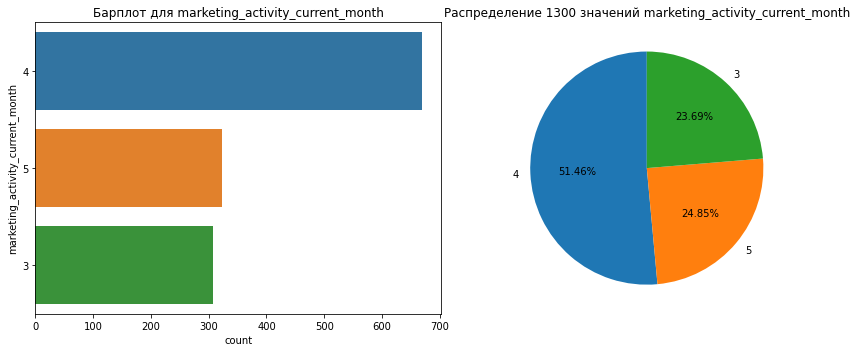

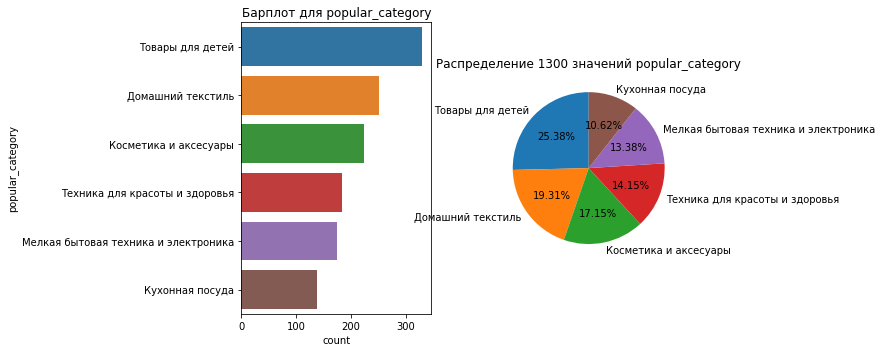

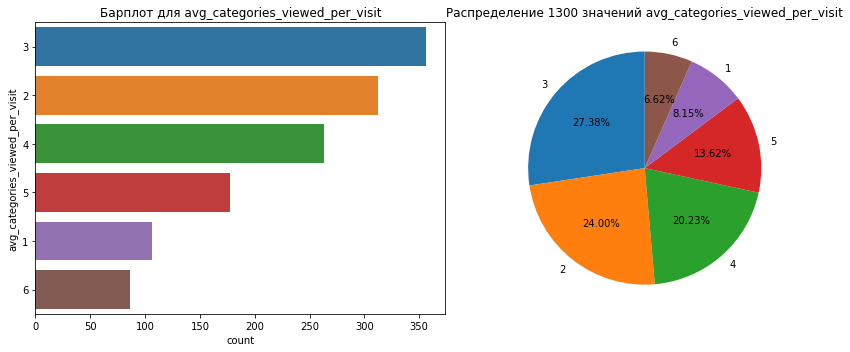

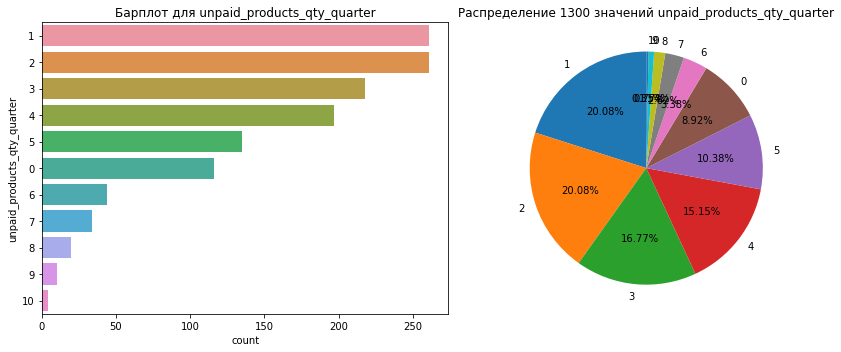

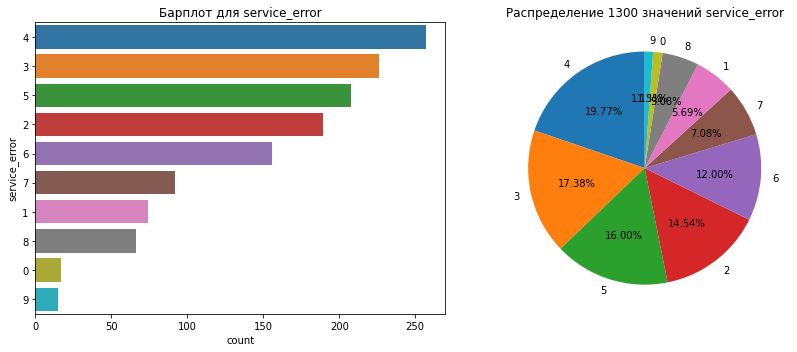

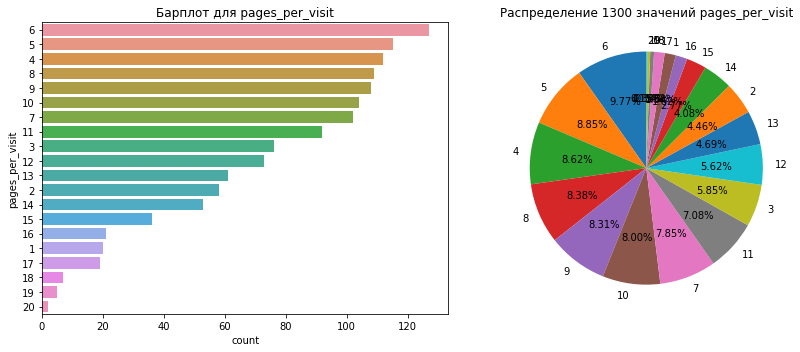

In [31]:
plotting_stat_graphs(
    market_file.loc[:, market_file.columns != 'id']
)

Опишем наблюдаемые распределения:

* marketing_activity_6_month
Наблюдения распределены куполообразно с пиком в 4 коммуникациях. Наблюдаются дискретные пики, что можно связать, например, с общими рассылками от магазина, приходящими всем согласившимся клиентам

* marketing_activity_current_month
Есть только три пика - 3, 4 и 5 коммуникаций. Это также может быть показателем общих рассылок

* duration
Имеем также куполообразное распределение с пиком на 600 днях. Каких-то закономерностей не наблюдается. Можно только заметить, что в данных нет новых пользователей, зарегистрировавшихся мене 110 дней назад

* promo_purchases
Наблюдаеются два пика - около 20% и около 90%. Левый пик может соответствовать обычным покупателям, а правый - тем, кто специально приходит в магазин за акциями, возможно, их привлекают специальные предложения

* avg_categories_viewed_per_visit
В среднем покупатели просматривают от 1 до 6 категорий за один визит. Особых закономерностей не наблюдается

* unpaid_products_qty_quarter
Смещенный влево пик показывает, что в корзине за 3 месяца лежат до 10 товаров. При этом чаще всего 1 или 2. Есть выбросы с 9 и 10 товарами

* service_error
Куполообразное распределение около 4

* pages_per_visit
Распределение похоже на unpaid_products_qty_quarter. За визит покупатели посещают до 20 страниц. При этом выбросы не найдены, то есть тех, кто смотрит много страниц не так мало

* customer_activity
У 62% активность осталась на прежнем уровне, у остальных - снизилась

* service_type
Премиум сервиса более чем в два раза меньше, чем стандарта

* allow_notifications
74% пользователей позволяют делать рассылку. То есть такой метод привлечения покупателей может быть действенным

* popular_category
Есть 6 категорий, наиболее представленными являются детские товары. Сильного перекоса в распределении нет

Посмотрим закономерности между группами с разной покупательской активностью

In [32]:
market_file.select_dtypes(include=['number']).columns

Index(['id', 'marketing_activity_6_months', 'marketing_activity_current_month',
       'duration', 'promo_purchases', 'avg_categories_viewed_per_visit',
       'unpaid_products_qty_quarter', 'service_error', 'pages_per_visit'],
      dtype='object')

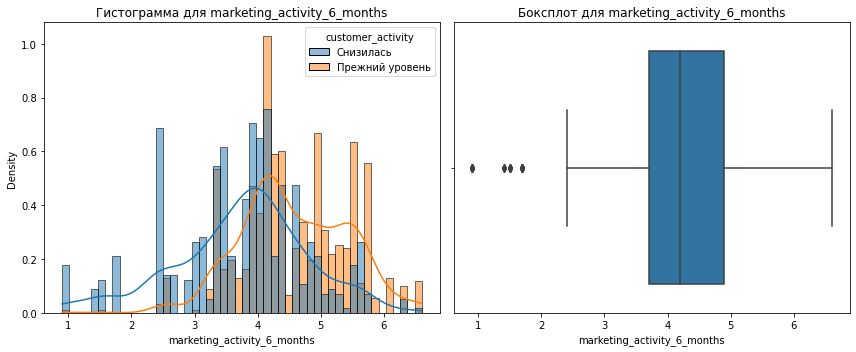

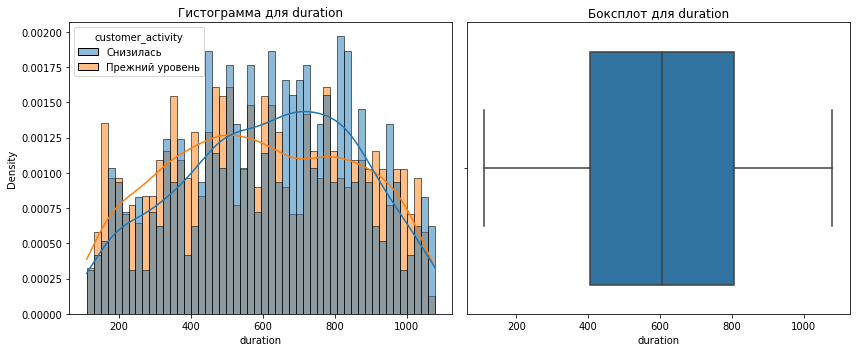

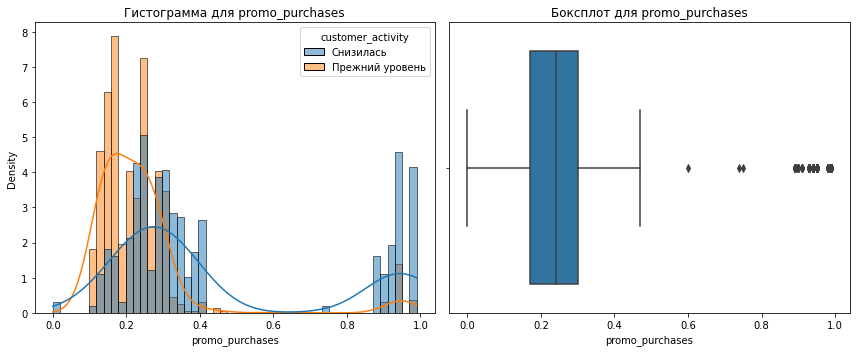

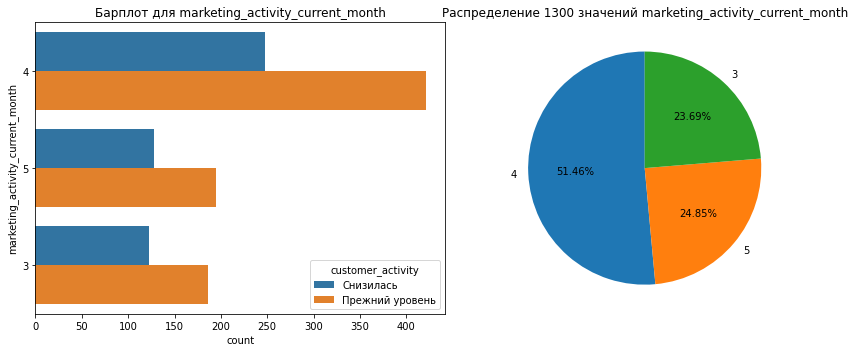

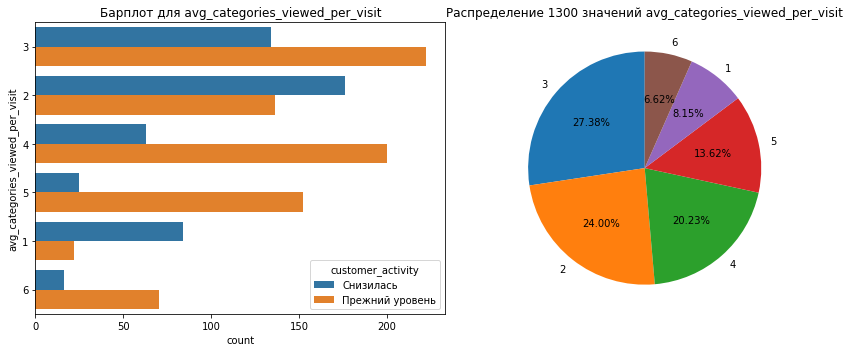

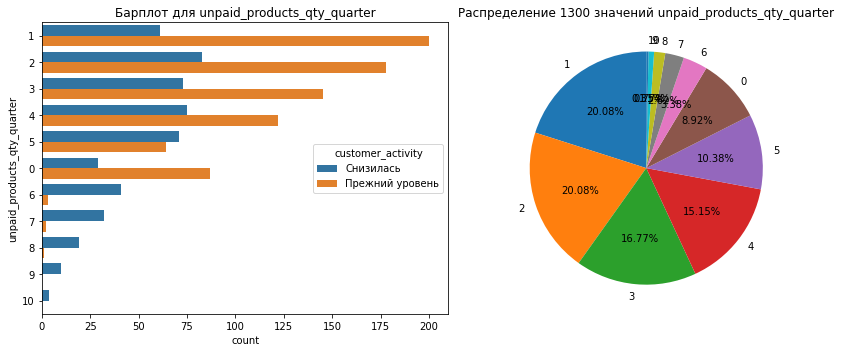

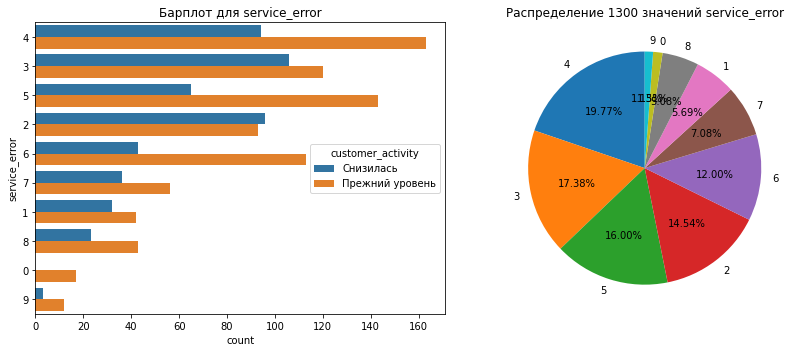

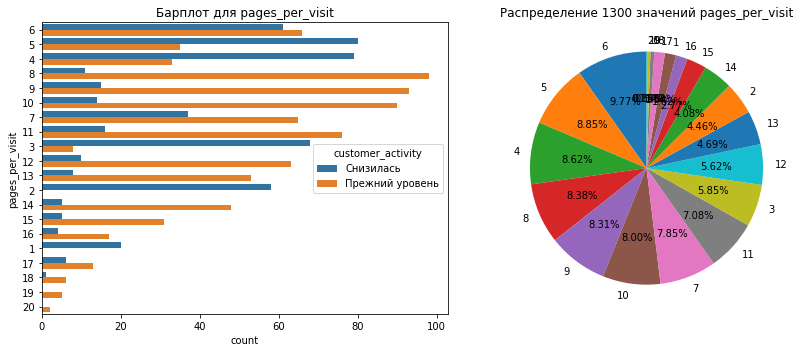

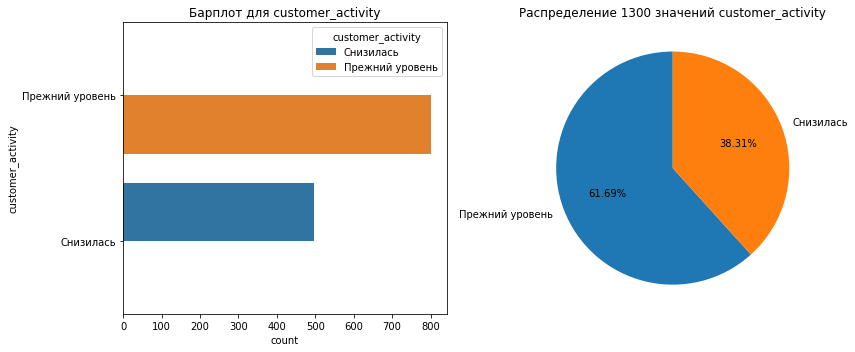

In [33]:
plotting_stat_graphs(
    market_file.loc[:, (
        market_file
        .drop(columns=['id'])
        .select_dtypes(include='number')
        .columns.to_list() + ['customer_activity']
    )],
    'customer_activity'
)

Здесь можно заметить определенные закономерности у покупателей со снизившейся активностью: 

* Чаще пользуются акциями
* Меньше категорий и страниц смотрят за раз
* Имеют больше вещей в корзине

Можно предположить, что часть из них изначально являются редкими пользователями сервиса, с чем отчасти и связано снижение

### market_money

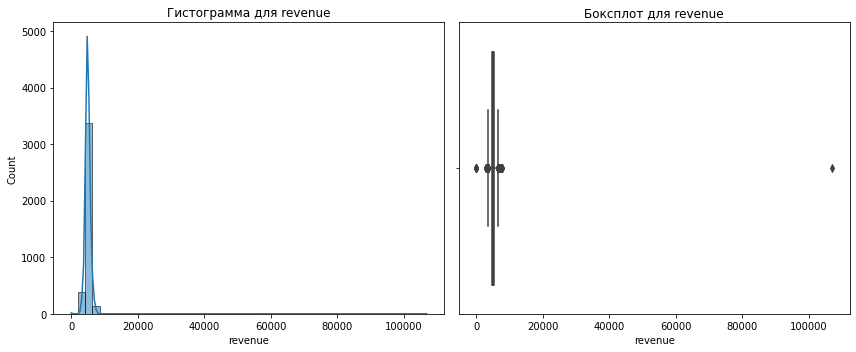

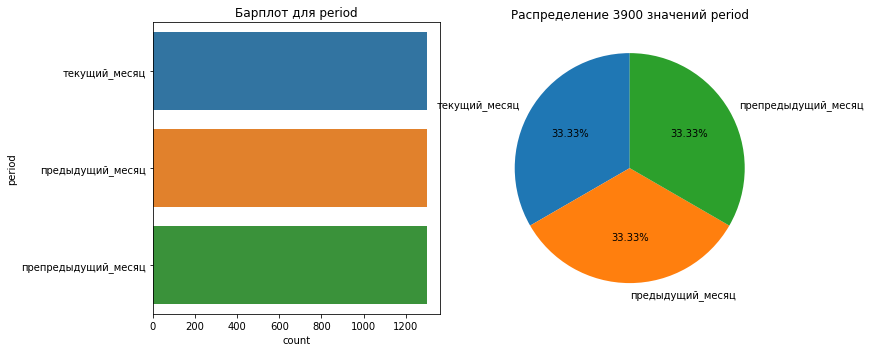

In [34]:
plotting_stat_graphs(market_money.loc[:, market_money.columns != 'id'])

Опишем наблюдаемые распределения:

* revenue
В выручке есть значение, которое в 20 раз превосходит медианное значение. Нужно будет посмотреть, что это за покупатель

* period
Три значения - "текущий месяц", "предыдущий месяц" и "препредыдущий меясц" имеют по 1300 записей

Выделим всех покупателей, от которых выручка выше 20000

In [35]:
id_4del = market_money.query('revenue > 20000')['id']

In [36]:
id_4del

98    215380
Name: id, dtype: int64

Посмотрим на пользователей

In [37]:
market_file[market_file['id'].isin(id_4del)]

,id,customer_activity,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


94% покупок клиента проходят по скидкам. При этом клиент находится в премиум сегменте. Имеет среднюю активность

удалим этих пользователей из всех таблиц

In [38]:
market_file = market_file.query('id not in @id_4del')
market_money = market_money.query('id not in @id_4del')
market_time = market_time.query('id not in @id_4del')
money = money.query('id not in @id_4del')

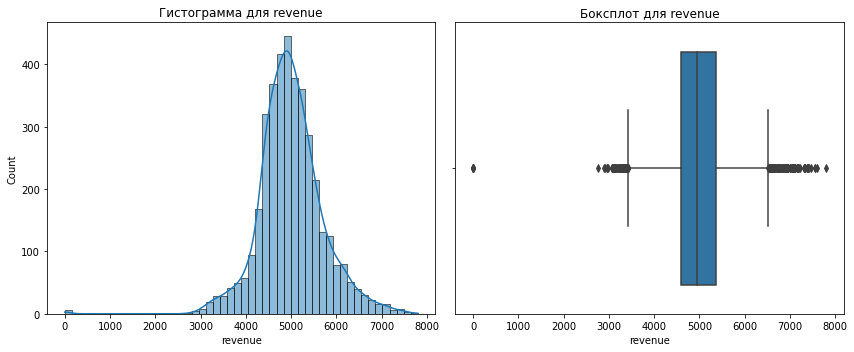

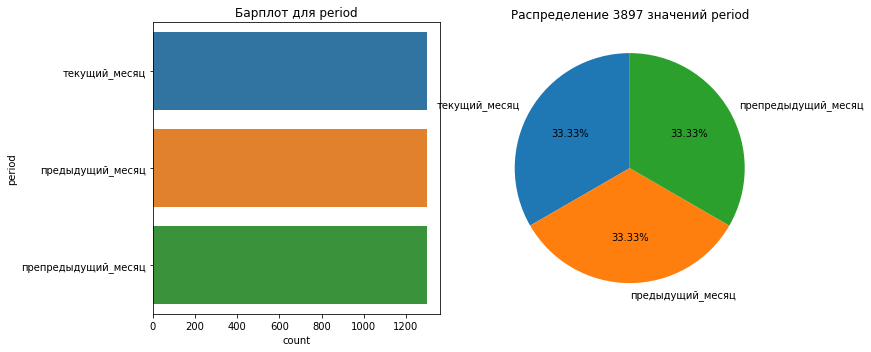

In [39]:
plotting_stat_graphs(market_money.loc[:, market_money.columns != 'id'])

### market_time

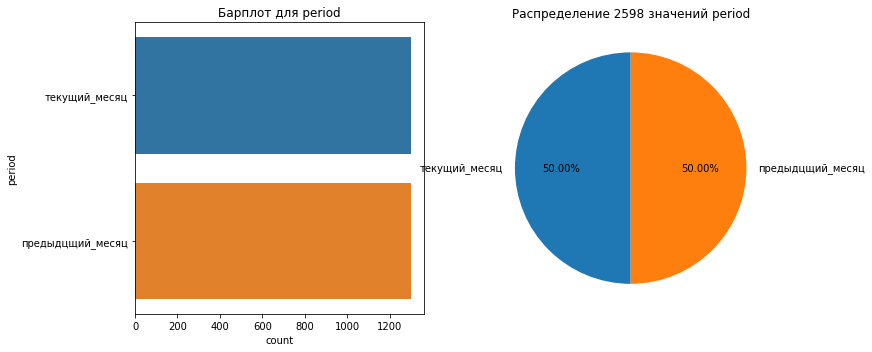

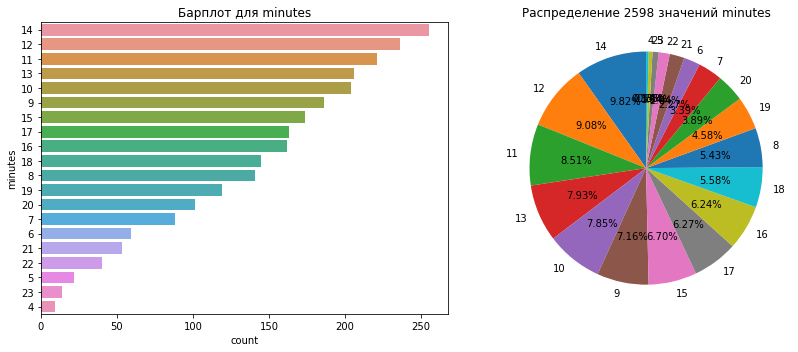

In [40]:
plotting_stat_graphs(market_time.loc[:, market_time.columns != 'id'])

Опишем полученные распределения:

* minutes
Куполообразное распределение около 13 минут. Без выбросов

* period
Данные ровно разделены на два периода - "текущия месяц" и "предыдущий месяц"

### money

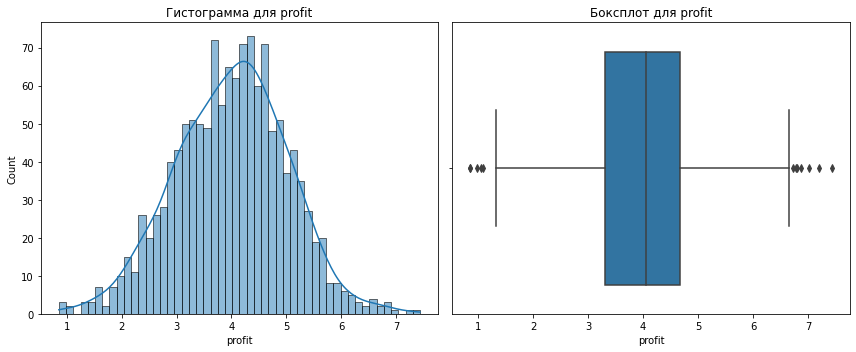

In [41]:
plotting_stat_graphs(money.loc[:, money.columns != 'id'])

Опишем полученные распределения:

* profit
Куполообразное распределение около 4; С обеих сторон есть выбросы  

### Оценка нормальности распределений количественных признаков

Мы заметили, что почти все количественные признаки распределены куполообразно. Проверим как близко это распределение к нормальному. Для этого воспользуемся статистическим тестом Шапиро-Уилка

H$_0$: Выборка $x_1, x_2, ..., x_n$ взята из нормально распределенной генеральной совокупности

H$_1$: Выборка $x_1, x_2, ..., x_n$ взята из не нормально распределенной генеральной совокупности

In [42]:
shapiro_results(market_file)

Тест Шапиро-Уилка для marketing_activity_6_months: p-value = 3.7974346432136097e-13

Тест Шапиро-Уилка для marketing_activity_current_month: p-value = 7.663361850852427e-37

Тест Шапиро-Уилка для duration: p-value = 5.534125336269756e-15

Тест Шапиро-Уилка для promo_purchases: p-value = 5.605193857299268e-45

Тест Шапиро-Уилка для avg_categories_viewed_per_visit: p-value = 4.427354035086283e-24

Тест Шапиро-Уилка для unpaid_products_qty_quarter: p-value = 1.0597449326795057e-23

Тест Шапиро-Уилка для service_error: p-value = 6.278531798104505e-17

Тест Шапиро-Уилка для pages_per_visit: p-value = 1.2628766576320422e-14



In [43]:
shapiro_results(market_money)

Тест Шапиро-Уилка для revenue: p-value = 9.253339303154616e-32



In [44]:
shapiro_results(market_time)

Тест Шапиро-Уилка для minutes: p-value = 2.4471637150930117e-17



Все полученные значения p-value получились очень маленькие, то есть гипотезу о нормальности распределений можно отвергнуть

## Отбор активных пользователей

Отберем пользователей, производивших покупку в последние три месяца

Соберем сводную таблицу с тратами прибылью от пользователей по периодам

In [45]:
market_money_pivot = (
    market_money
    .pivot(
        index='id',
        columns='period',
        values='revenue'
    )
)

market_money_pivot

period,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


Нам нужны id покупателей, выручка от которых за препредыдущий месяц больше 0

In [46]:
active_user_ids = (
    market_money_pivot
    .loc[market_money_pivot['препредыдущий_месяц'] > 0]
    .index
    .to_numpy()
)

print(f'В данных есть {active_user_ids.shape[0]} активных пользователей')
print(f'Это {active_user_ids.shape[0] / market_money_pivot.shape[0]:.1%}')

В данных есть 1296 активных пользователей
Это 99.8%


Таким образом, почти все пользователи, представленные в таблице являются активными

Посмотрим на неактивных пользователей

In [47]:
(
    market_file
    .loc[~market_file['id'].isin(
        market_money_pivot
        .loc[market_money_pivot['препредыдущий_месяц'] > 0]
        .index
        .to_list()
    )]
)

,id,customer_activity,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2


У всех разрешена рассылка, у одного из покупателей было большое количество сервисных ошибок

## Промежуточный вывод

В таблице `market_file`:

* marketing_activity_6_month

Наблюдения распределены куполообразно с пиком в 4 коммуникациях. Наблюдаются дискретные пики, что можно связать, например, с общими рассылками от магазина, приходящими всем согласившимся клиентам

* marketing_activity_current_month

Есть только три пика - 3, 4 и 5 коммуникаций. Это также может быть показателем общих рассылок

* duration

Имеем также куполообразное распределение с пиком на 600 днях. Каких-то закономерностей не наблюдается. Можно только заметить, что в данных нет новых пользователей, зарегистрировавшихся мене 110 дней назад

* promo_purchases

Наблюдаеются два пика - около 20% и около 90%. Левый пик может соответствовать обычным покупателям, а правый - тем, кто специально приходит в магазин за акциями, возможно, их привлекают специальные предложения

* avg_categories_viewed_per_visit

В среднем покупатели просматривают от 1 до 6 категорий за один визит. Особых закономерностей не наблюдается

* unpaid_products_qty_quarter

Смещенный влево пик показывает, что в корзине за 3 месяца лежат до 10 товаров. При этом чаще всего 1 или 2. Есть выбросы с 9 и 10 товарами

* service_error

Куполообразное распределение около 4

* pages_per_visit

Распределение похоже на unpaid_products_qty_quarter. За визит покупатели посещают до 20 страниц. При этом выбросы не найдены, то есть тех, кто смотрит много страниц не так мало

* customer_activity

У 62% активность осталась на прежнем уровне, у остальных - снизилась

* service_type

Премиум сервиса более чем в два раза меньше, чем стандарта

* allow_notifications

74% пользователей позволяют делать рассылку. То есть такой метод привлечения покупателей может быть действенным

* popular_category

Есть 6 категорий, наиболее представленными являются детские товары. Сильного перекоса в распределении нет

Здесь можно заметить определенные закономерности у покупателей со снизившейся активностью: 

* Чаще пользуются акциями
* Меньше категорий и страниц смотрят за раз
* Имеют больше вещей в корзине

Можно предположить, что часть из них изначально являются редкими пользователями сервиса, с чем отчасти и связано снижение

В таблице `market_money`:

* revenue

В выручке есть значение, которое в 20 раз превосходит медианное значение. Нужно будет посмотреть, что это за покупатель

* period

Три значения - "текущий месяц", "предыдущий месяц" и "препредыдущий меясц" имеют по 1300 записей. 94% покупок клиента проходят по скидкам. При этом клиент находится в премиум сегменте. Имеет среднюю активность

В таблице `market_time`:

* minutes

Куполообразное распределение около 13 минут. Без выбросов

* period

Данные ровно разделены на два периода - "текущия месяц" и "предыдущий месяц"

В таблице `money`:

* profit

Куполообразное распределение около 4; С обеих сторон есть выбросы  

99.8% представленных пользователей названы активнми, то есть теми, кто совершал покупки в последние три месяца. Есть только 3 неактивных покупателя

# Объединение таблиц

Объединим таблицы market_file, market_money, market_time 

Сначала создадим сводные таблицы на основе market_time и market_money

In [48]:
period_columns = {
        'предыдущий_месяц': 'previous_month',
        'предыдцщий_месяц': 'previous_month', # Замечена ошибка в market_time
        'препредыдущий_месяц': 'pre_previous_month',
        'текущий_месяц': 'current_month'
    }

market_money_pivot.rename(
    columns=period_columns,
    inplace=True
)

In [49]:
market_time_pivot = (
    market_time
    .pivot(
        index='id',
        columns='period',
        values='minutes'
    )
    .rename(
        columns=period_columns
    )
)

Объединяем таблицы. Сразу отберем активных покупателей. В качестве индекса поставим id

In [50]:
market_full = market_file.join(
    market_money_pivot.add_suffix('_revenue'),
    on='id',
).join(
    market_time_pivot.add_suffix('_minutes'),
    on='id'
).query('id in @active_user_ids').set_index('id')

Проверим таблицу

In [51]:
data_info(market_full)


-----Пример данных-----



,customer_activity,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit,previous_month_revenue,pre_previous_month_revenue,current_month_revenue,previous_month_minutes,current_month_minutes
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10



-----Информация о данных-----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_activity                 1296 non-null   object 
 1   service_type                      1296 non-null   object 
 2   allow_notifications               1296 non-null   object 
 3   marketing_activity_6_months       1296 non-null   float64
 4   marketing_activity_current_month  1296 non-null   int64  
 5   duration                          1296 non-null   int64  
 6   promo_purchases                   1296 non-null   float64
 7   popular_category                  1296 non-null   object 
 8   avg_categories_viewed_per_visit   1296 non-null   int64  
 9   unpaid_products_qty_quarter       1296 non-null   int64  
 10  service_error                     1296 non-null   int64  
 11  pages_per_visit               

None


-----Статистическое опиасние данных-----



,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit,previous_month_revenue,pre_previous_month_revenue,current_month_revenue,previous_month_minutes,current_month_minutes
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,4.256404,4.009259,602.967593,0.320069,3.267747,2.841821,4.184414,8.187500,4947.468750,4836.202160,5238.096065,13.470679,13.210648
std,1.013525,0.696316,249.195823,0.249159,1.355125,1.974074,1.951719,3.978459,700.797239,333.514091,834.318717,3.937630,4.221794
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,409.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.125000,4584.500000,4706.050000,10.750000,10.000000
50%,4.200000,4.000000,606.500000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4810.500000,5179.950000,13.000000,13.000000
75%,4.900000,4.000000,806.250000,0.300000,4.000000,4.000000,6.000000,11.000000,5405.625000,5056.000000,5759.275000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


In [52]:
market_full.isna().sum()

customer_activity                   0
service_type                        0
allow_notifications                 0
marketing_activity_6_months         0
marketing_activity_current_month    0
duration                            0
promo_purchases                     0
popular_category                    0
avg_categories_viewed_per_visit     0
unpaid_products_qty_quarter         0
service_error                       0
pages_per_visit                     0
previous_month_revenue              0
pre_previous_month_revenue          0
current_month_revenue               0
previous_month_minutes              0
current_month_minutes               0
dtype: int64

## Промежуточные выводы

На данном шаге объединили таблицы `market_file`, `market_money`, `market_time`. При этом из таблиц `market_money` и `market_time` взяли данные за каждый из периодов отдельно. Убрали из данных 3 неактивных пользователя. Полученная таблица не имеет пропусков, имеет корректную типизацию

# Корреляционный анализ

На этапе исследовательского анализа мы проверили, что нет данных, описываемых нормальным распреледелением. Поэтому использовать корреляцию Пирса не нужно. Посмотрим корреляцию Спирмена 

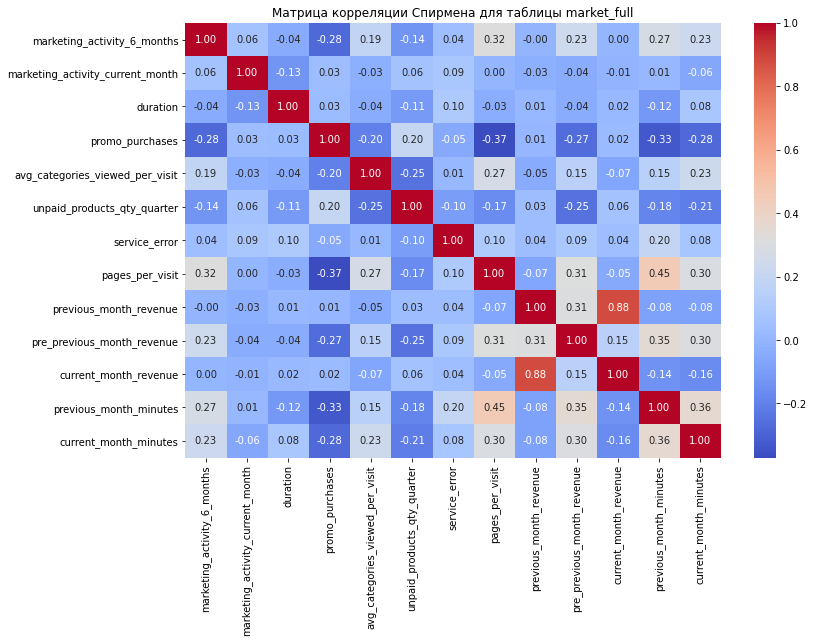

In [53]:
plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции Спирмена для таблицы market_full')
sns.heatmap(
    market_full.select_dtypes(include=["number"]).corr('spearman'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
);

И для всех признаков построим $\phi_k$ матрицу

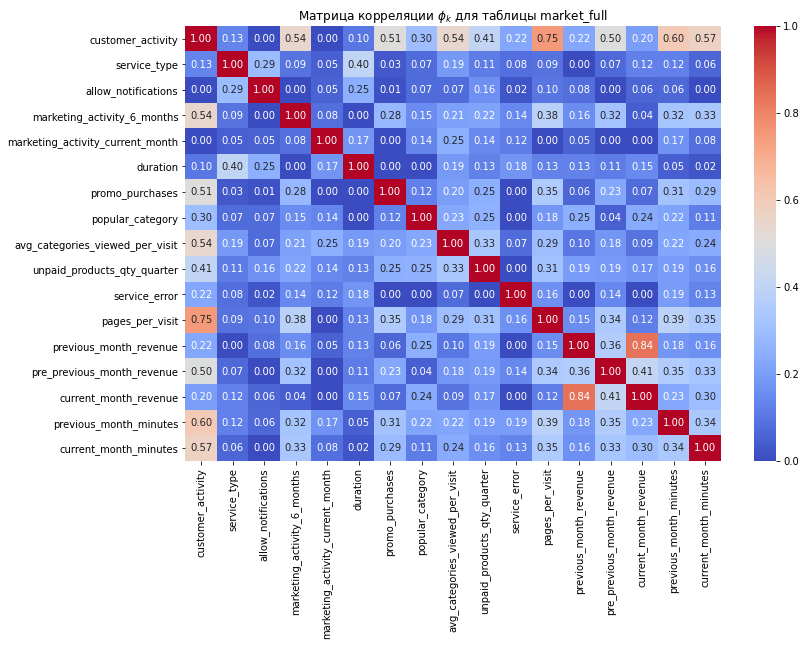

In [54]:
plt.figure(figsize=(12, 8))
plt.title(r'Матрица корреляции $\phi_k$ для таблицы market_full')
sns.heatmap(
    market_full.phik_matrix(interval_cols=[
    'marketing_activity_6_months', 
    'duration', 
    'promo_purchases', 
    'pre_previous_month_revenue', 
    'previous_month_revenue', 
    'current_month_revenue'
]),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
);

## Проверка мультиколлинеарности

Проверим VIF для более точной оценки

In [55]:
dlt = market_full.select_dtypes(include=['number'])
dlt = add_constant(dlt)

VIFs = pd.DataFrame()
VIFs['Variable'] = dlt.columns
VIFs['VIF'] = [variance_inflation_factor(dlt.values, i)\
               for i in range(dlt.shape[1])]

VIFs

,Variable,VIF
0,const,352.524089
1,marketing_activity_6_months,1.220849
2,marketing_activity_current_month,1.044578
3,duration,1.099452
4,promo_purchases,1.185679
5,avg_categories_viewed_per_visit,1.178602
6,unpaid_products_qty_quarter,1.198629
7,service_error,1.079350
8,pages_per_visit,1.418264
9,previous_month_revenue,4.263015


## Промежуточные выводы:


1. **Матрица корреляции Спирмена** (числовые переменные)
- **Заметные корреляции**:
  - `previous_month_revenue` и `current_month_revenue`: **0.88** — очень сильная положительная связь. Это указывает на потенциальную мультиколлинеарность, так как эти переменные могут дублировать информацию о доходах. Чуть менее выражена связь с `pre_previous_month_revenue` (**0.31**)
  - `previous_month_minutes`, `current_month_minutes`: **0.36** - слабая связь.
  - `pages_per_visit` и `previous_month_minutes`: **0.45** — умеренная положительная связь.
  - `pre_previous_month_revenue` и `previous_month_revenue`: **0.31** — слабая связь, но стоит учитывать в совокупности с другими корреляциями.

- **Заметные отрицательные корреляции**:
  - `marketing_activity_6_months` и `promo_purchases`: **-0.28** — слабая отрицательная связь.
  - `promo_purchases` и `pages_per_visit`: **-0.37** — умеренная отрицательная связь.

1. **Матрица корреляции $\phi_k$** (категориальные и числовые переменные)
- **Заметные корреляции**:
  - `customer_activity` и `pages_per_visit`: **0.75** — очень сильная связь. 
  - `customer_activity` и `previous_month_minutes`: **0.6** — сильная связь.
  - `customer_activity` и `marketing_activity_6_months`: **0.54** 
  - `pages_per_visit` и `previous_month_minutes`: **0.39** — умеренная связь.
  - `service_type` и `duration`: **0.40** — умеренная связь.
  - `allow_notifications` и `duration`: **0.25** — слабая связь.

Оценка с помощью VIF показала все коэффициенты ниже 5, что говорит о низкой коллинеарности между численными данными. Таким образом, проблем, связанных с мультиколлинеарностью возникнуть не должно

# Использование пайплайнов

Разделим столбцы по разным способам предобработки

In [56]:
ord_columns = [
    'service_type', 
    'allow_notifications'
]

ohe_columns = [
    'popular_category'
]

num_columns = market_full.select_dtypes(include=['number']).columns.to_list()

## Сборка пайплайна

Пайплайн для OneHotEncoding

In [57]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

Пайплайн для OrdinalEncoder

In [58]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет']
                ],
                handle_unknown='use_encoded_value', 
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Соберем вместе предобработку данных

In [59]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

Присоединим шаг с моделированием - сделаем финальный пайплайн

In [60]:
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

## Определение сетки гиперпараметров

Составим сетку гиперпараметров

In [61]:
param_distributions = [
#     словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),    
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2,10),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
#     словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 5),
        'models__C': np.logspace(-3, 3, 7),
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear'
            )],
        'models__penalty': ['l1', 'l2'],
        'models__C': np.logspace(-3, 3, 7), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

## Поиск оптимальных параметров

In [62]:
X = market_full.drop(columns=['customer_activity'], axis=1)
y = market_full['customer_activity']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

target_mark = np.where(le.classes_ == 'Снизилась')[0][0]
print(f'Целевая метка снижения: {target_mark}')

Целевая метка снижения: 1


В поставленной задаче нужно точно выделить покупателей, у которых активность снизится. В дальнейшем для таких клиентов будут разрабатываться специальные предложения. Для того, чтобы не потерять клиентов и вовремя их привлечь, нужно повышать метрику recall. При этом, если делать особые предложения тем, кто на самом деле не уходит, магазин также может начать терять не клиентов, но уже деньги, по этому будем использовать f1-метрику. 

На первом шаге мы рассмотрим четыре классификатора  `KNeighborsClassifier`, `DecisionTreeClassifier`, `LogisticRegression` и `SVC`. С помощью RandomizedSearchCV с использованием метрики f1_score мы выберем лучшую модель (данная метрика поможет "подогнать" модель под нашу задачу)

In [63]:
# gscv = RandomizedSearchCV(
#     final_pipe, 
#     param_distributions, 
#     cv=5,
#     scoring='f1',
#     n_jobs=-1,
#     random_state=RANDOM_STATE,
#     n_iter=1
# )

In [64]:
gscv = GridSearchCV(
    final_pipe, 
    param_distributions, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
)

In [65]:
gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['popular_category']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleI...
                          'models__gamma': ['scale', 'auto'],
                          'models__kernel': ['linear', 'poly', 'rbf',
                                             'sigmoid'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'models': [LogisticRegression(random_state=42,
                                                        solver='liblinear')],
                          'models__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'models__penalty': ['l1', 'l2'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             scoring='f1')

In [66]:
cv_results(gscv)

,param_models,param_preprocessor__num,param_models__max_depth,param_models__max_features,param_models__min_samples_split,param_models__C,param_models__degree,param_models__gamma,param_models__kernel,params,mean_test_score
0,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,2.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.838078
1,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,4.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.838078
2,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,3.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.838078
3,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,2.0,auto,rbf,"{'models': SVC(probability=True, random_state=...",0.835140
4,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,3.0,auto,rbf,"{'models': SVC(probability=True, random_state=...",0.835140
...,...,...,...,...,...,...,...,...,...,...,...
1419,"SVC(probability=True, random_state=42)",MinMaxScaler(),NaN,NaN,NaN,0.100,4.0,auto,sigmoid,"{'models': SVC(probability=True, random_state=...",0.000000
1420,"SVC(probability=True, random_state=42)",MinMaxScaler(),NaN,NaN,NaN,0.010,2.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.000000
1421,"SVC(probability=True, random_state=42)",MinMaxScaler(),NaN,NaN,NaN,0.010,2.0,scale,sigmoid,"{'models': SVC(probability=True, random_state=...",0.000000
1422,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,0.010,2.0,auto,poly,"{'models': SVC(probability=True, random_state=...",0.000000


In [67]:
display(gscv.best_params_)
display(gscv.best_score_)

{'models': SVC(probability=True, random_state=42),
 'models__C': 1.0,
 'models__degree': 2,
 'models__gamma': 'scale',
 'models__kernel': 'rbf',
 'preprocessor__num': StandardScaler()}

0.8380777551841382

In [68]:
cv_results(gscv)

,param_models,param_preprocessor__num,param_models__max_depth,param_models__max_features,param_models__min_samples_split,param_models__C,param_models__degree,param_models__gamma,param_models__kernel,params,mean_test_score
0,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,2.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.838078
1,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,4.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.838078
2,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,3.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.838078
3,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,2.0,auto,rbf,"{'models': SVC(probability=True, random_state=...",0.835140
4,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,1.000,3.0,auto,rbf,"{'models': SVC(probability=True, random_state=...",0.835140
...,...,...,...,...,...,...,...,...,...,...,...
1419,"SVC(probability=True, random_state=42)",MinMaxScaler(),NaN,NaN,NaN,0.100,4.0,auto,sigmoid,"{'models': SVC(probability=True, random_state=...",0.000000
1420,"SVC(probability=True, random_state=42)",MinMaxScaler(),NaN,NaN,NaN,0.010,2.0,scale,rbf,"{'models': SVC(probability=True, random_state=...",0.000000
1421,"SVC(probability=True, random_state=42)",MinMaxScaler(),NaN,NaN,NaN,0.010,2.0,scale,sigmoid,"{'models': SVC(probability=True, random_state=...",0.000000
1422,"SVC(probability=True, random_state=42)",StandardScaler(),NaN,NaN,NaN,0.010,2.0,auto,poly,"{'models': SVC(probability=True, random_state=...",0.000000


Посмотрим на каком значении $\gamma$ остановилась модель

In [69]:
gscv.best_estimator_['models']._gamma

0.07010139666303045

Низкое значение, то есть граница довольно свободна

In [70]:
best_pipe = gscv.best_estimator_

In [71]:
best_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_freque...
                                                   'marketing_activity_current_month',
                                                   'duration',
                                                   'promo_purchases',
                                                   'avg_categories_viewed_per_visit',
                                                   'unpaid_products_qty_quarter',
                                                   'service_error',
                                                   'pages_per_visit',
                                                   'previous_month_revenue',
                                                   'pre_previous_month_revenue',
                                                   'current_month_revenue',
                                                   'previous_month_minutes',
                                                   'current_month_minutes'])])),
                ('models', SVC(degree=2, probability=True, random_state=42))])

In [72]:
best_model = best_pipe.named_steps['models']

## Пормежуточные выводы

На данном шаге был собран полный пайплайн подготовки данных и использования модели. Для выбора лучшей модели среди KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC() использовали GridSearchCV с метрикой f1_score. По результатам подбора наилучшей оказалась модель SVC. Вторым шагом GridSearchCV использовался для подбора лучших параметров этой модели с оценкой roc_auc_score. 

Получившиеся оптимальные параметры оказались следующими:
* Обработка количественных признаков: `StandardScaler()`
* Лучшая модель: `SVC(C=np.float64(1.0), random_state=42, gamma='scale')`

На тестовых данных она показала следующие метрики:
* f1-мера: 0.876
* roc_auc_score: 0.919

# Анализ важности признаков

После подбора параметров оптимальной модели посмотрим на то, какие признаки оказались важными, а какие - нет

Воспользуемся значениями Шепли

Сначала преобразуем X_train, X_test до формата, в котором они подаются в модель в нашем пайплайне

In [73]:
feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()

X_train_prepared = pd.DataFrame(
    best_pipe.named_steps['preprocessor'].transform(X_train),
    columns=feature_names
)
X_test_prepared = pd.DataFrame(
    best_pipe.named_steps['preprocessor'].transform(X_test),
    columns=feature_names
)

Вычислим коэффициенты

In [74]:
# f = lambda x: best_pipe.named_steps['models'].predict_proba(x)[:, 1]
f = lambda x: best_model.decision_function(x) # Более фундаментальный метод для предсказания

explainer = shap.KernelExplainer(
    f, 
    shap.sample(X_train_prepared, 2, random_state=RANDOM_STATE)
)

In [75]:
shap_values = explainer(X_test_prepared[:5])

  0%|          | 0/5 [00:00<?, ?it/s]

In [76]:
# with open('shap_values.pickle', 'wb') as f:
#     pickle.dump(shap_values, f, pickle.HIGHEST_PROTOCOL)

In [77]:
# with open('shap_values.pickle', 'rb') as f:
#     shap_values = pickle.load(f)

In [78]:
!pip freeze

absl-py==1.2.0
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1622150326904/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1624539388359/work/dist
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522573621/work
astunparse==1.6.3
async-generator==1.10
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1620387926260/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1619719576210/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4==4.9.3
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1612213472466/work
blinker==1.4
blis==0.7.8
branca==0.5.0
brotlipy==0.7.0
cachetools==5.2.0
catalogue==2.0.8
catboost==1.0.3
certifi==2022.6.15
certipy==0.1.3
cffi @ file:///home/conda/feedstock_root/b

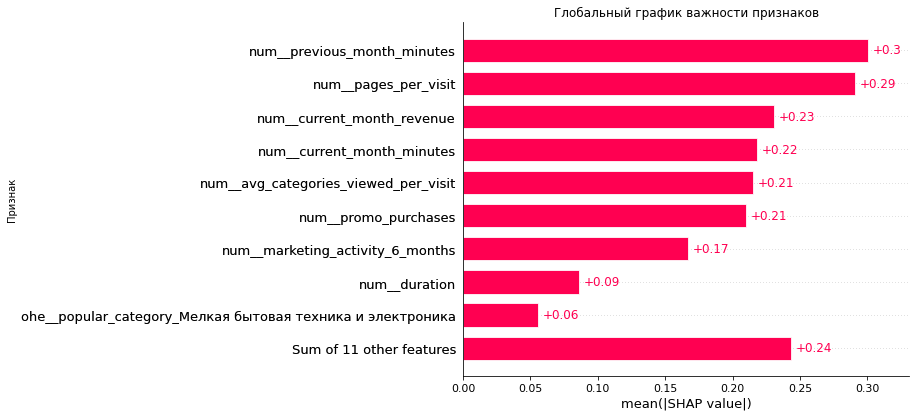

In [79]:
# shap.initjs()
import shap
import matplotlib

shap.plots.bar(shap_values, show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(axis='y', labelsize=13)
ax.set_title('Глобальный график важности признаков')
ax.set_ylabel('Признак')

plt.show()

In [80]:
shap_values_df = (
    pd.DataFrame(
        np.abs(shap_values.values).mean(axis=0),
        index=shap_values.feature_names,
        columns=['shap']
    )
    .sort_values(by='shap', ascending=False)
    .reset_index()
)

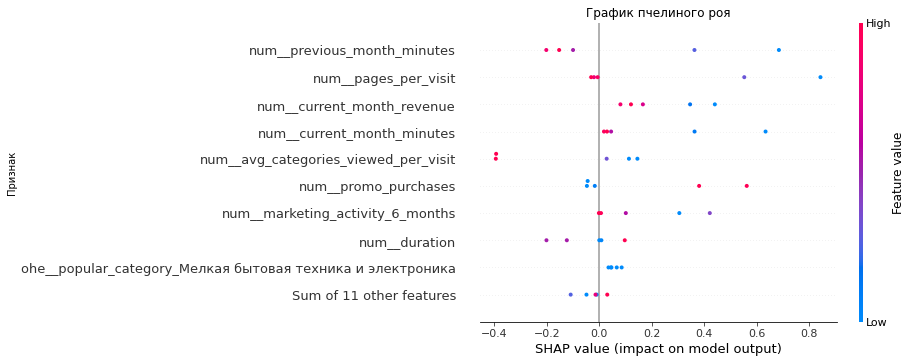

In [81]:
shap.plots.beeswarm(shap_values, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.set_title('График пчелиного роя')
ax.set_ylabel('Признак')

plt.show()

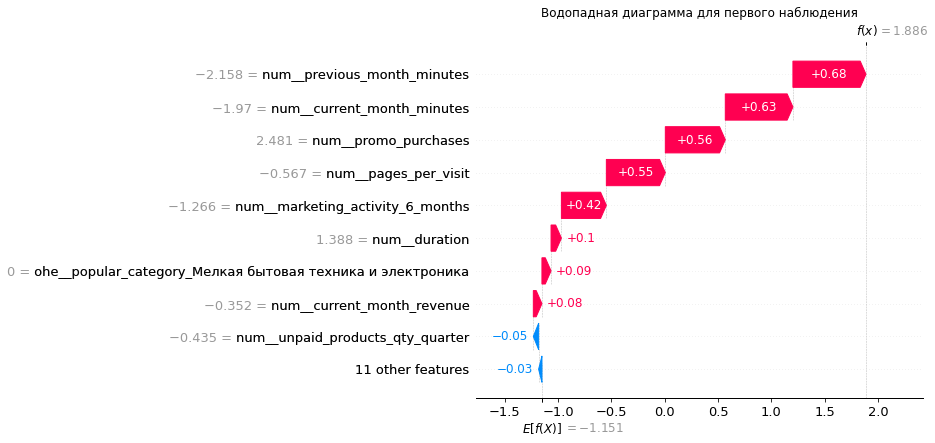

In [82]:
shap.plots.waterfall(shap_values[0], show=False)

fig, ax = plt.gcf(), plt.gca()

ax.set_title('Водопадная диаграмма для первого наблюдения')
ax.set_ylabel('Признак')

plt.show()

## Промежуточные выводы

На основе значений Шепли для нашей модели и данных можно заключить, что наиболее значимыми являются столбцы: 
* 'num__pages_per_visit',
* 'num__previous_month_minutes',
* 'num__current_month_minutes',
* 'num__promo_purchases',
* 'num__avg_categories_viewed_per_visit',
* 'num__unpaid_products_qty_quarter',
* 'num__marketing_activity_6_months',
* 'num__pre_previous_month_revenue',
* 'num__previous_month_revenue'

Со средними абсолютными значениями Шепли от 0.05 до 0.2. Все они прямо связаны с активностью покупателя в сревисе, а значит и с его покупательской активностью. То есть результат выглядит рационально

По значениям beeswarm видны следующие закономерности:
* Чем меньше страниц смотрит покупатель за висит, тем больше модель склоняется к тому, что он уйдет
* Аналогично с временем в сервисе
* Если покупатель все больше покупает по скидке, тем менее устойчивым видит его модель
* Аналогично с неоплаченными вещами

Наименее значимыми (со значением Шепли меньше 0.025) значения являются:
* 'ohe__popular_category_Мелкая бытовая техника и электроника',
 * 'ohe__popular_category_Техника для красоты и здоровья',
 * 'ord__service_type',
 * 'ohe__popular_category_Кухонная посуда',
 * 'ohe__popular_category_Товары для детей',
 * 'ohe__popular_category_Косметика и аксесуары',
 * 'ord__allow_notifications',
 * 'num__current_month_revenue'

Видно, что они по большей части связаны с популярными категориями и выручкой, что уже не так сильно в действительности связано с клиентами, использующими магазин "разных товаров" - для улучшения модели попробуем убрать эти значения из датасета

## Улучшение модели

Попробуем обучить ранее полученную лучшую модель на данных без маловажных признаках

У нас есть подготовленные выборки, прошедшие через трансформацию нашего пайплайна, так что мы на этом шаге можем просто убрать из них ненужные столбы, не обучая повторно

In [83]:
shap_threshold = shap_values_df['shap']

roc_auc_scores = []
f1_scores = []

for threshold in shap_threshold:
    X_train_prepared_important = (
        X_train_prepared
        .drop(columns=shap_values_df.query('shap < @threshold')['index'])
    )

    roc_auc_scores.append(cross_val_score(
        best_model,
        X_train_prepared_important,
        y_train,
        cv=5, 
        scoring='roc_auc'
    ).mean())

    f1_scores.append(cross_val_score(
        best_model,
        X_train_prepared_important,
        y_train,
        cv=5, 
        scoring='f1'
    ).mean())

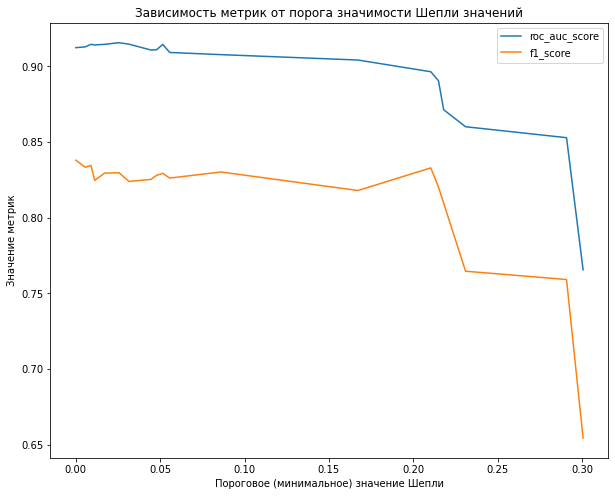

In [84]:
plt.figure(figsize=(10, 8))

plt.plot(
    shap_threshold,
    roc_auc_scores,
    label='roc_auc_score'
)

plt.plot(
    shap_threshold,
    f1_scores,
    label='f1_score'
)

plt.title('Зависимость метрик от порога значимости Шепли значений')
plt.xlabel('Пороговое (минимальное) значение Шепли')
plt.ylabel('Значение метрик')

plt.legend()
plt.show()

In [85]:
_ = shap_threshold[np.array(roc_auc_scores).argmax()]
print(f'Для максимизации roc_auc нужно убрать признаки со значением Шепли ниже\
 {_:.3n}')
print(f'Метрика увеличивается на {max(roc_auc_scores) - roc_auc_scores[-1]}')
print(f'\tПри этом убирается {shap_values_df.query("shap < @_").shape[0]}\
 признаков:')
print(shap_values_df.query('shap < @_')['index'])
print()
_ = shap_threshold[np.array(f1_scores).argmax()]
print(f'Для максимизации f1 нужно убрать признаки со значением Шепли ниже\
 {_:.3n}')
print(f'Метрика увеличивается на {max(f1_scores) - f1_scores[-1]}')
print(f'\tПри этом убирается {shap_values_df.query("shap < @_").shape[0]}\
 признаков:')
print(shap_values_df.query('shap < @_')['index'])


Для максимизации roc_auc нужно убрать признаки со значением Шепли ниже 0.0255
Метрика увеличивается на 0.003301319791973234
	При этом убирается 6 признаков:
14                                    ord__service_type
15               ohe__popular_category_Товары для детей
16                                   num__service_error
17                ohe__popular_category_Кухонная посуда
18    ohe__popular_category_Техника для красоты и зд...
19          ohe__popular_category_Косметика и аксесуары
Name: index, dtype: object

Для максимизации f1 нужно убрать признаки со значением Шепли ниже 0
Метрика увеличивается на 0.0
	При этом убирается 0 признаков:
Series([], Name: index, dtype: object)


При удалении признаков улучшение слишком мало - это скорее случайность. Так что изменять модель не будем

## Проверка лучшего пайплайна на тестовых данных

Посмотрим какие метрики будут у нашего оптимального пайплайна на тестовой выборке

f1-мера: 0.87568
roc_auc_score: 0.90953


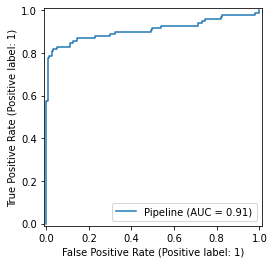

In [86]:
y_pred = best_pipe.predict(X_test)
print(f'f1-мера: {round(f1_score(y_test, y_pred), 5)}')

y_proba = best_pipe.predict_proba(X_test)[:, 1]
print(f'roc_auc_score: {round(roc_auc_score(y_test, y_proba), 5)}')

RocCurveDisplay.from_estimator(best_pipe, X_test, y_test);

f1-мера: 0.0
roc_auc_score: 0.5


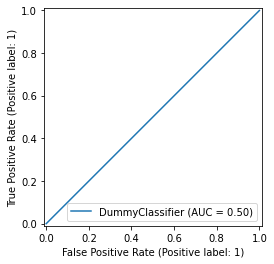

In [87]:
dc = DummyClassifier()

dc.fit(X_train, y_train)

y_dummy_pred = dc.predict(X_test)
print(f'f1-мера: {round(f1_score(y_test, y_dummy_pred), 5)}')

y_dummy_proba = dc.predict_proba(X_test)[:, 1]
print(f'roc_auc_score: {round(roc_auc_score(y_test, y_dummy_proba), 5)}')

RocCurveDisplay.from_estimator(dc, X_test, y_test);

На тестовой выборке используемые метрики выше, чем средняя при кросс-валидации при поиске гиперпарамтеров. Также модель лучше DummyClassifier(). В дальнейшем продолжем использовать этот пайплайн

# Сегментация покупателей

Соберем обратно полный датасет X_test, добавив туда результат предсказаний нашей модели и информацию из таблицы `money`

In [88]:
market_test = X_test.join(money.set_index('id'), how='left')

market_test

,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit,previous_month_revenue,pre_previous_month_revenue,current_month_revenue,previous_month_minutes,current_month_minutes,profit
id,,,,,,,,,,,,,,,,,
215402,премиум,да,3.0,5,954,0.93,Товары для детей,3,2,4,6,4918.0,4702.0,4940.1,5,5,4.28
216035,премиум,нет,3.8,4,570,0.14,Товары для детей,2,1,2,13,3615.0,4763.0,4739.5,16,13,5.68
215701,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2,4685.5,4444.0,5161.3,9,7,5.05
215860,стандарт,да,5.5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,5.34
215761,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,2.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215628,стандарт,да,4.0,4,618,0.93,Товары для детей,3,5,2,2,3783.0,4566.0,3848.0,9,10,4.11
215590,стандарт,нет,2.4,4,427,0.29,Товары для детей,5,8,3,4,4321.0,4604.0,4640.8,12,14,4.14
216392,стандарт,да,4.6,5,356,0.17,Товары для детей,3,4,3,13,4973.0,4819.0,4969.1,20,9,3.68


In [89]:
market_test['decline_probability'] = y_proba

market_test

,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit,previous_month_revenue,pre_previous_month_revenue,current_month_revenue,previous_month_minutes,current_month_minutes,profit,decline_probability
id,,,,,,,,,,,,,,,,,,
215402,премиум,да,3.0,5,954,0.93,Товары для детей,3,2,4,6,4918.0,4702.0,4940.1,5,5,4.28,0.993185
216035,премиум,нет,3.8,4,570,0.14,Товары для детей,2,1,2,13,3615.0,4763.0,4739.5,16,13,5.68,0.104720
215701,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2,4685.5,4444.0,5161.3,9,7,5.05,0.981626
215860,стандарт,да,5.5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,5.34,0.062479
215761,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,2.60,0.049268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215628,стандарт,да,4.0,4,618,0.93,Товары для детей,3,5,2,2,3783.0,4566.0,3848.0,9,10,4.11,0.995778
215590,стандарт,нет,2.4,4,427,0.29,Товары для детей,5,8,3,4,4321.0,4604.0,4640.8,12,14,4.14,0.944570
216392,стандарт,да,4.6,5,356,0.17,Товары для детей,3,4,3,13,4973.0,4819.0,4969.1,20,9,3.68,0.078596


## Построение диаграмм рассеяния

Построим диаграммы рассеяния

In [90]:
num_columns_pairgrid = np.hstack([np.append(
    market_test
    .select_dtypes(include=['number'])
    .drop(columns=['decline_probability'], axis=1)
    .columns
    .to_numpy(),
    ''
    ).reshape((5, 3)),
    np.array(['decline_probability'] * 5, dtype=object).reshape(-1, 1)
])

num_columns_pairgrid

array([['marketing_activity_6_months',
        'marketing_activity_current_month', 'duration',
        'decline_probability'],
       ['promo_purchases', 'avg_categories_viewed_per_visit',
        'unpaid_products_qty_quarter', 'decline_probability'],
       ['service_error', 'pages_per_visit', 'previous_month_revenue',
        'decline_probability'],
       ['pre_previous_month_revenue', 'current_month_revenue',
        'previous_month_minutes', 'decline_probability'],
       ['current_month_minutes', 'profit', '', 'decline_probability']],
      dtype=object)

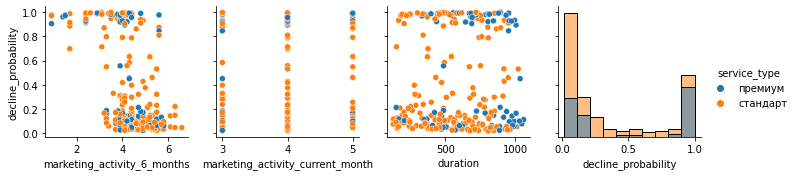

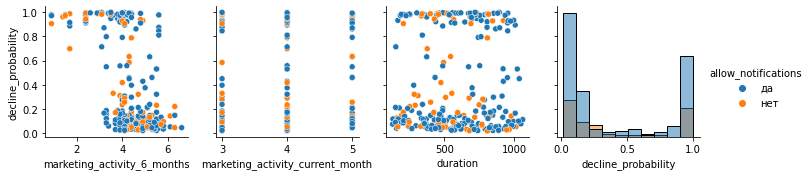

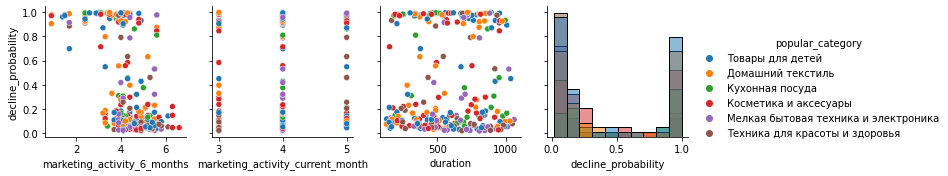

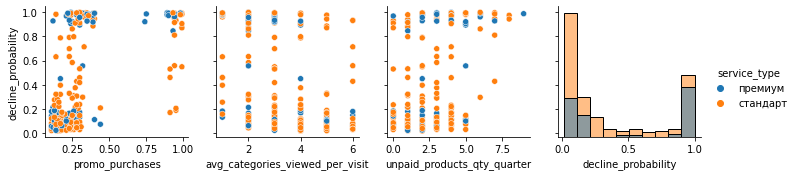

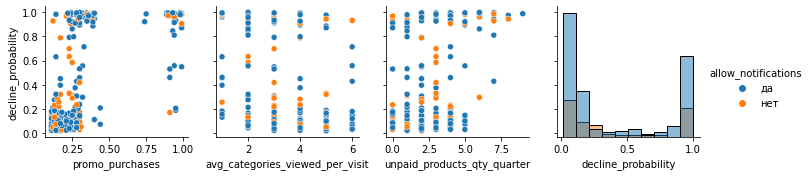

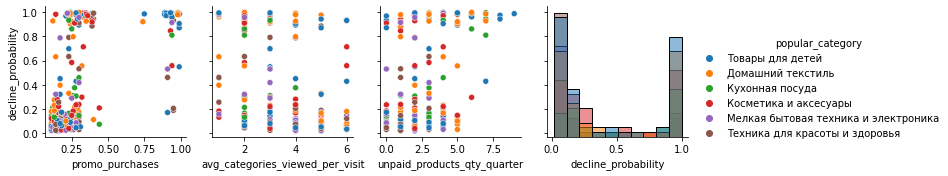

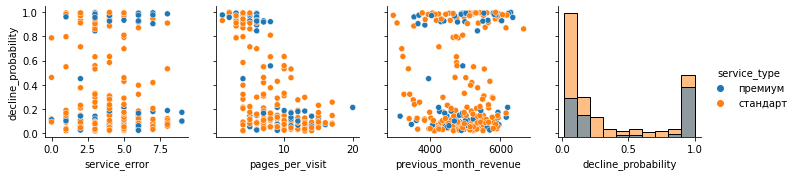

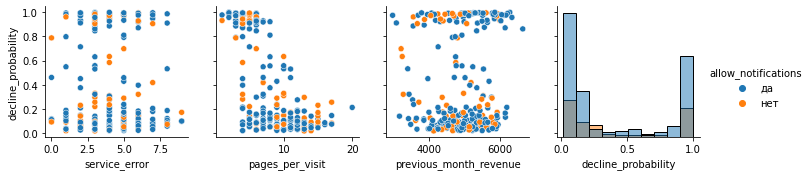

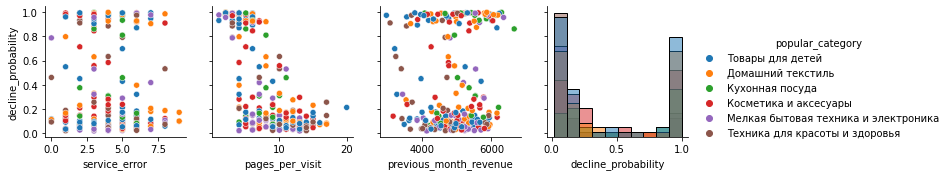

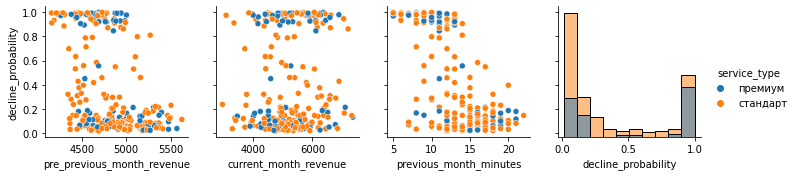

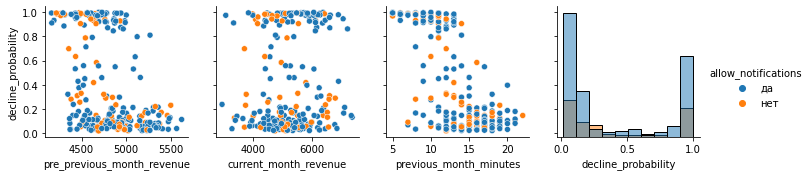

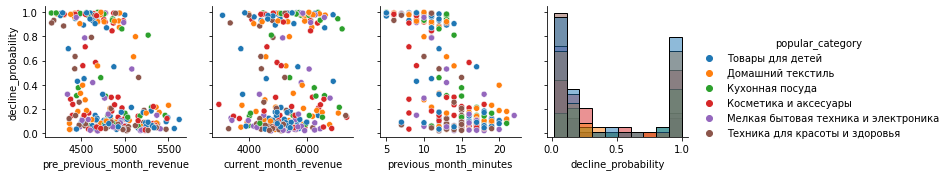

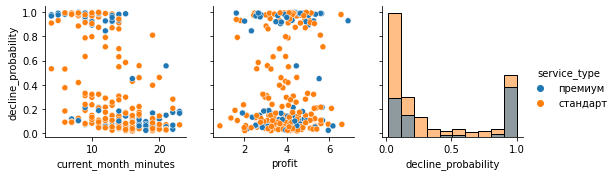

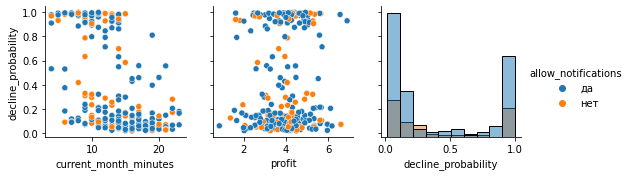

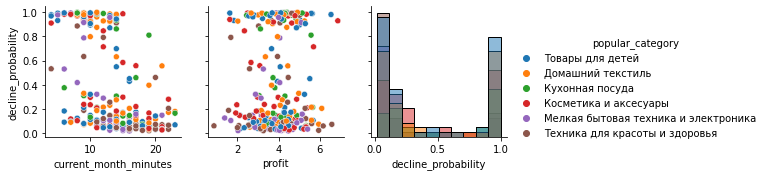

In [91]:
for columns in num_columns_pairgrid:
    columns = columns[~np.isin(columns, '')]
    for cat in market_test.select_dtypes(exclude=['number']).columns:
        g = sns.PairGrid(
            market_test, 
            x_vars=columns, 
            y_vars=['decline_probability'],
            hue=cat
        )
        g.map_diag(sns.histplot, color=".3")
        g.map_offdiag(sns.scatterplot)
        g.add_legend()

Дополнительно добавим еще категориальный признак на основе численного:

* `promo_purchases` -> `frequent_purchases`

Если доля акционных покупок у человека больше 50%, то запишем частые акционные покупки, иначе - редкие

In [92]:
market_test['frequent_purchases'] = (
    market_test
    .apply(lambda row: 'Частые акционные покупки'\
           if row['promo_purchases'] > 0.5\
           else 'Редкие акционные покупки', axis=1)
)

market_test.head()

,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit,previous_month_revenue,pre_previous_month_revenue,current_month_revenue,previous_month_minutes,current_month_minutes,profit,decline_probability,frequent_purchases
id,,,,,,,,,,,,,,,,,,,
215402,премиум,да,3.0,5,954,0.93,Товары для детей,3,2,4,6,4918.0,4702.0,4940.1,5,5,4.28,0.993185,Частые акционные покупки
216035,премиум,нет,3.8,4,570,0.14,Товары для детей,2,1,2,13,3615.0,4763.0,4739.5,16,13,5.68,0.104720,Редкие акционные покупки
215701,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2,4685.5,4444.0,5161.3,9,7,5.05,0.981626,Частые акционные покупки
215860,стандарт,да,5.5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,5.34,0.062479,Редкие акционные покупки
215761,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,2.60,0.049268,Редкие акционные покупки


## Выбор сегмента

Посмотрим на связь прибыли с вероятностью снижения активности

In [93]:
market_test.head()

,service_type,allow_notifications,marketing_activity_6_months,marketing_activity_current_month,duration,promo_purchases,popular_category,avg_categories_viewed_per_visit,unpaid_products_qty_quarter,service_error,pages_per_visit,previous_month_revenue,pre_previous_month_revenue,current_month_revenue,previous_month_minutes,current_month_minutes,profit,decline_probability,frequent_purchases
id,,,,,,,,,,,,,,,,,,,
215402,премиум,да,3.0,5,954,0.93,Товары для детей,3,2,4,6,4918.0,4702.0,4940.1,5,5,4.28,0.993185,Частые акционные покупки
216035,премиум,нет,3.8,4,570,0.14,Товары для детей,2,1,2,13,3615.0,4763.0,4739.5,16,13,5.68,0.104720,Редкие акционные покупки
215701,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2,4685.5,4444.0,5161.3,9,7,5.05,0.981626,Частые акционные покупки
215860,стандарт,да,5.5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,5.34,0.062479,Редкие акционные покупки
215761,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,3713.8,12,18,2.60,0.049268,Редкие акционные покупки


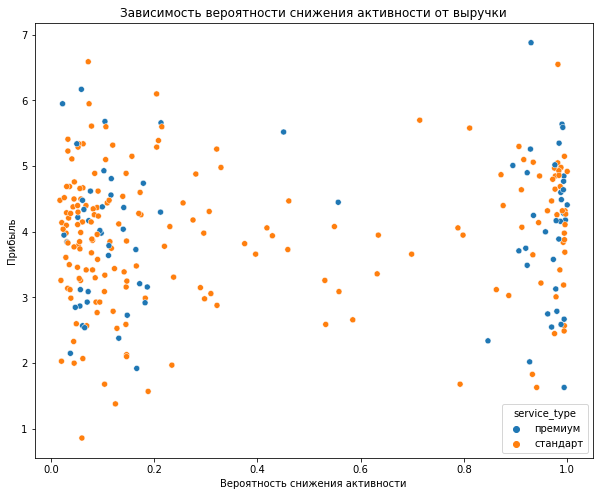

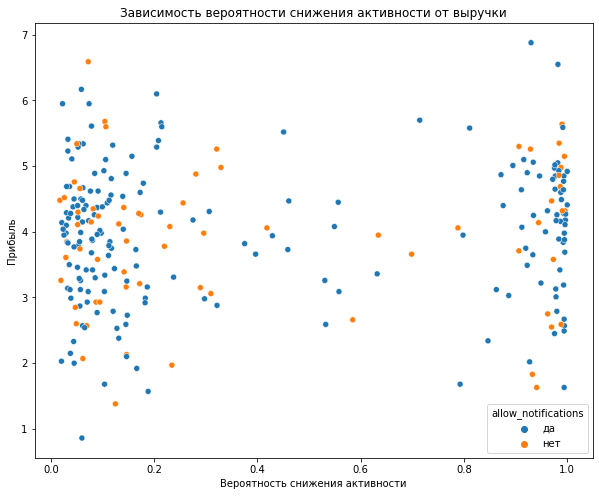

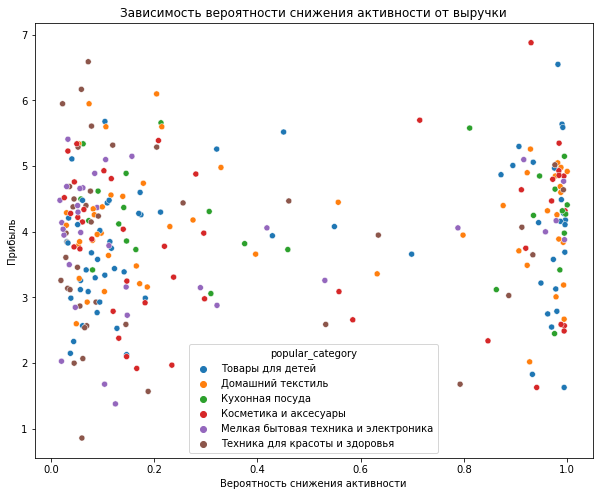

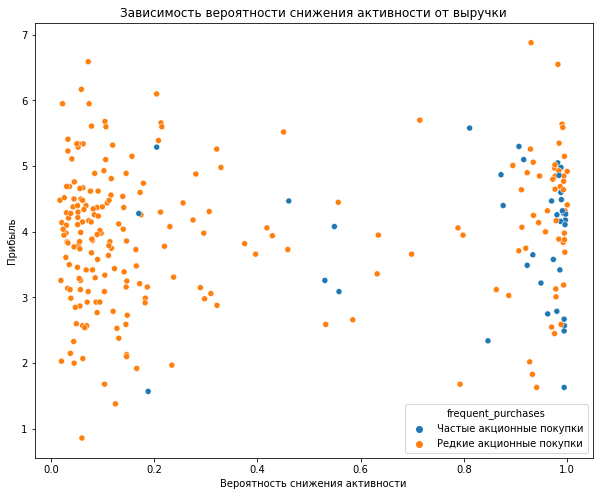

In [94]:
for cat_col in market_test.select_dtypes(exclude=['number']).columns:
        fig = plt.figure(figsize=(10, 8))
        sns.scatterplot(
                data=market_test, 
                y='profit', 
                x='decline_probability', 
                hue=cat_col
            )
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.show()

Таким образом, можно наглядно увидеть - люди, часто покупаюзие по акции, в основном находятся в зоне риска ухода - тот же результат мы получили с помощью расчета показателей Шепли. В дальнейшем рассмотрим часто закупающихся по акции "рисковых" покупателей.

In [95]:
market_test['segment'] = (
    market_test
    .apply(lambda row: 1\
           if row['frequent_purchases'] == 'Частые акционные покупки'\
           and row['decline_probability'] > 0.5\
           else 0,
           axis=1
        )
)

## Изучение выбранного сегмента

Еще раз построим все основные графики, которые мы строили в исследовательском анализе

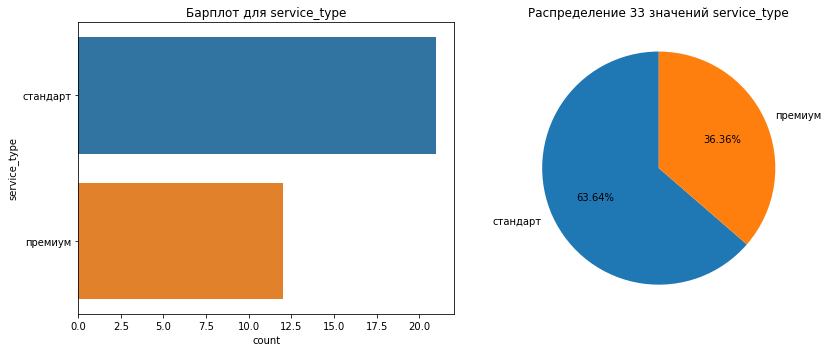

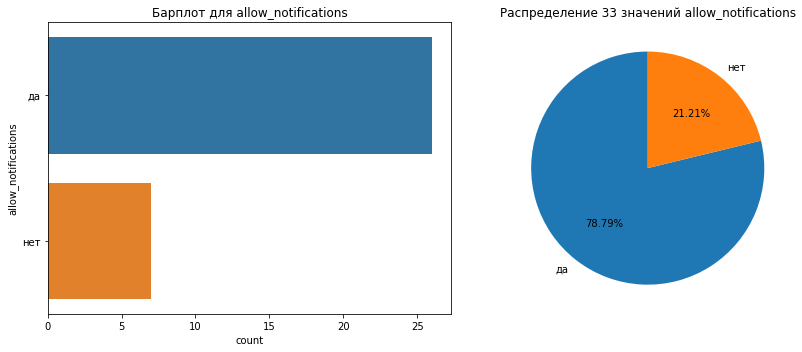

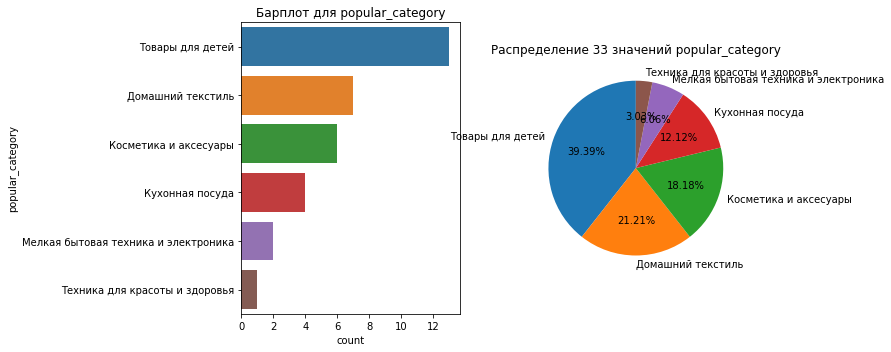

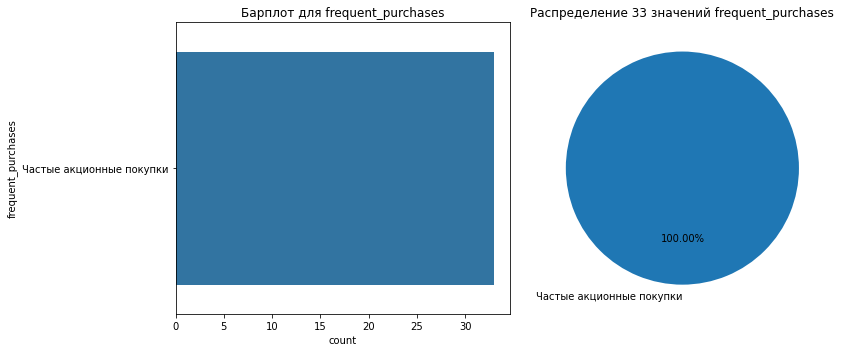

In [96]:
plotting_stat_graphs(
    market_test[market_test['segment'] == 1]
    .select_dtypes(exclude=['number'])
)

Можно заметить, что в популярных категориях с отрывом лидирует домашний текстиль (29%) и товары для детей (26%). Ремонт или воспитание ребенка действительно требуют большей финансовой ответственности, что заставляет больше внимания уделять скидкам

Также 66% рассматриваемых людей имеют стандартный тип сервиса, при этом все-таки по большей части (80%) готовы к получению уведомлений. 

Посмотрим на изменение распределений числовых признаков

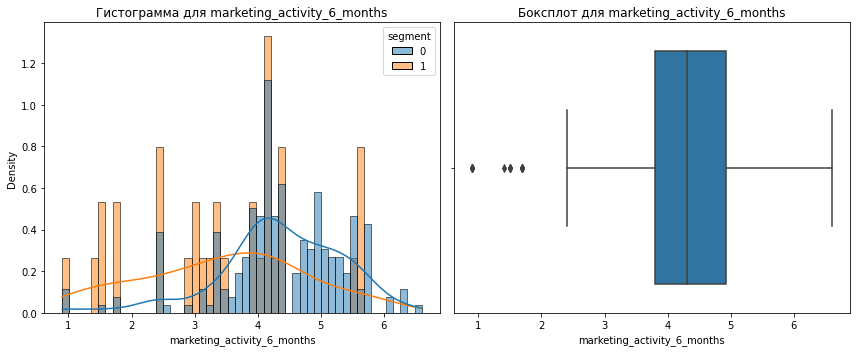

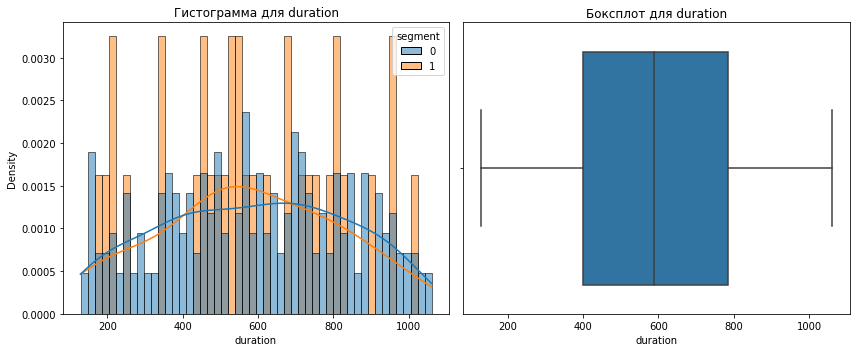

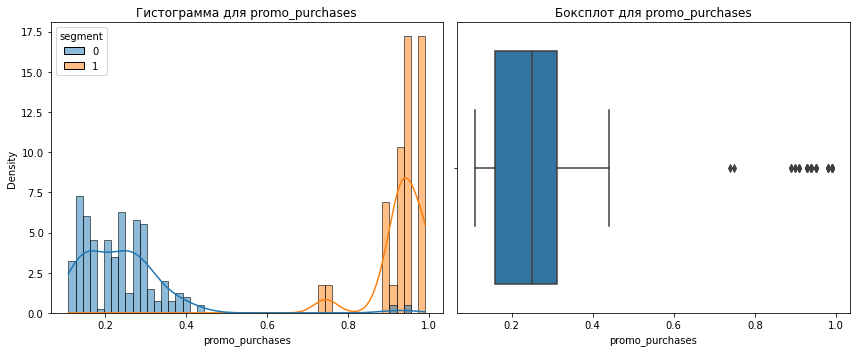

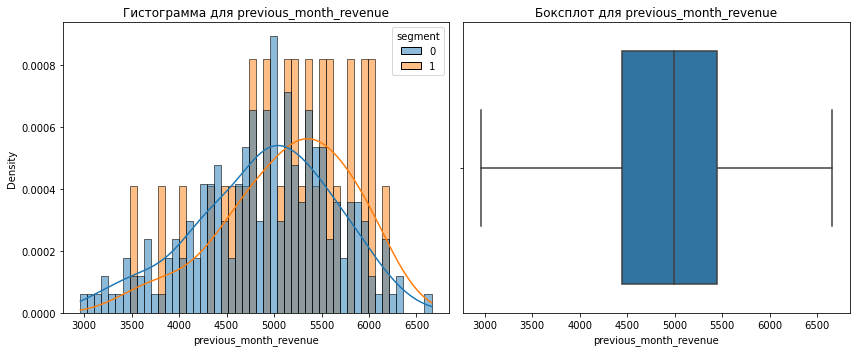

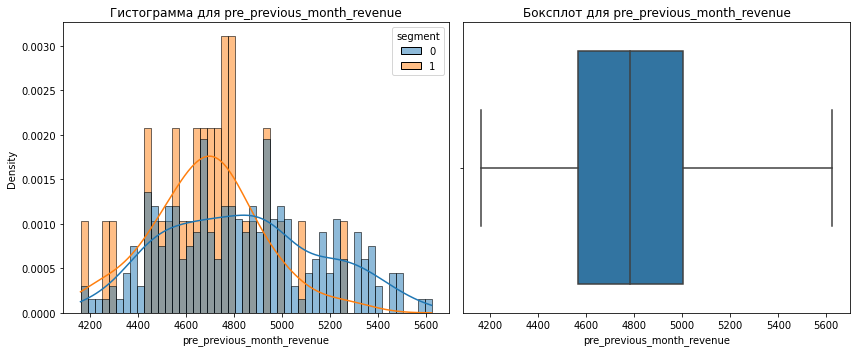

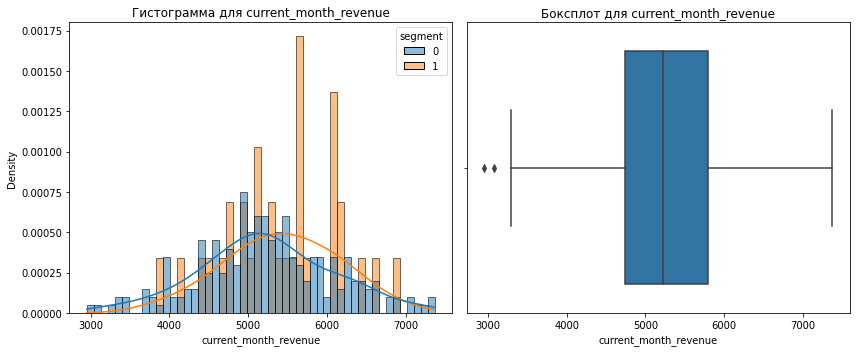

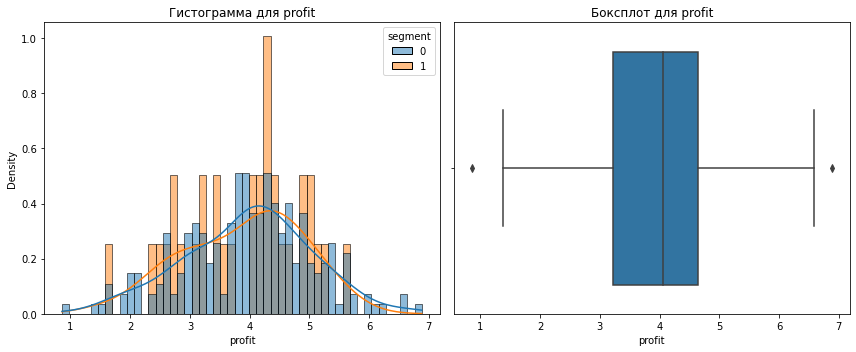

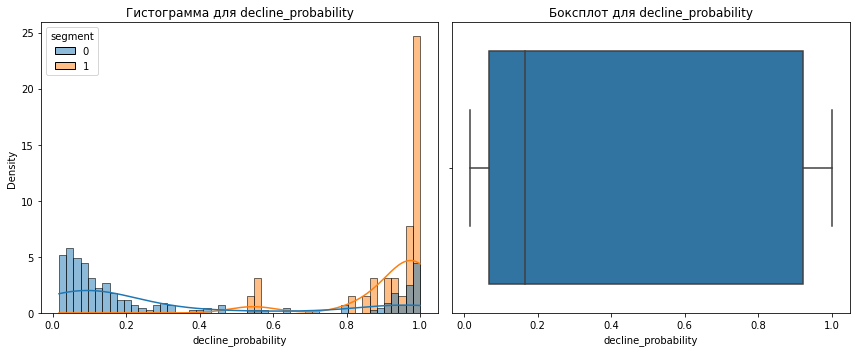

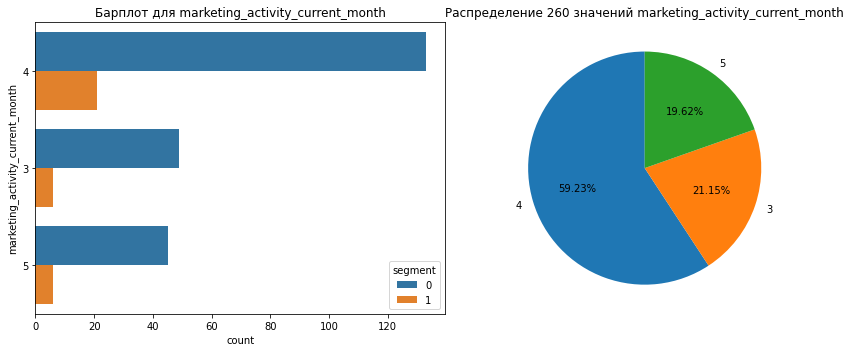

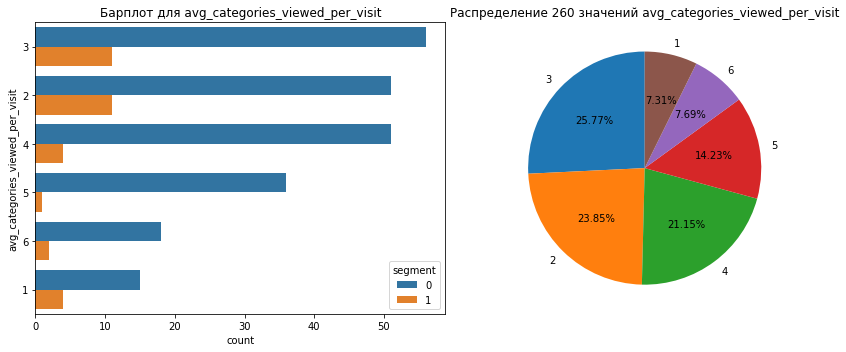

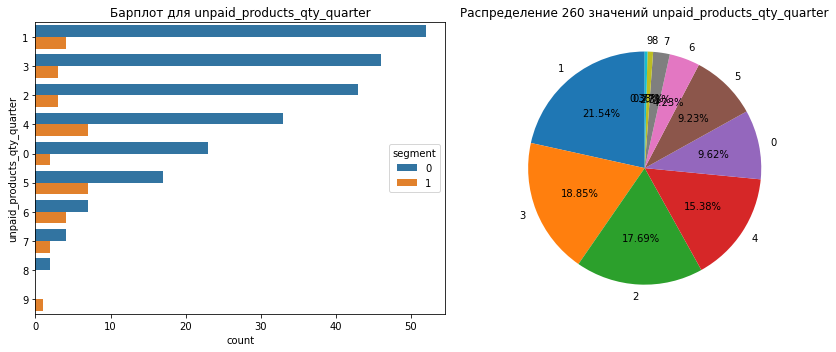

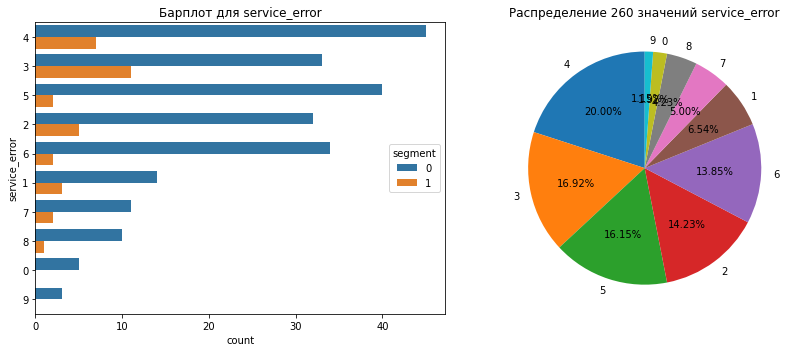

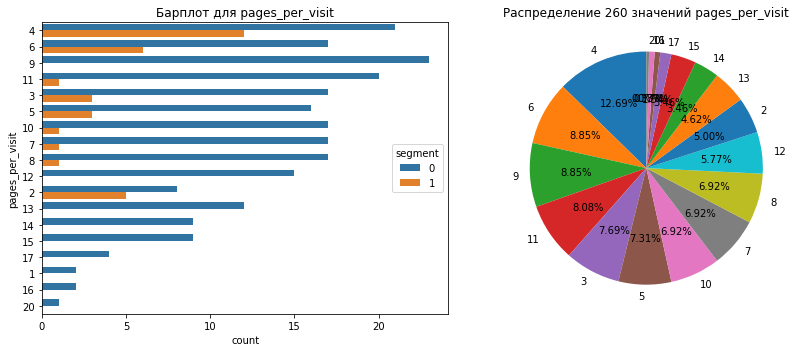

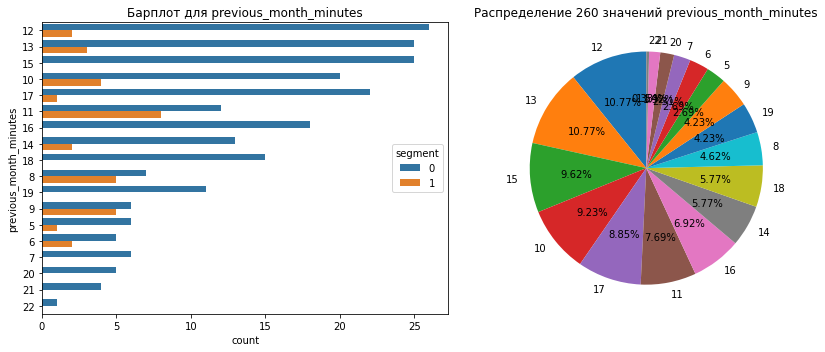

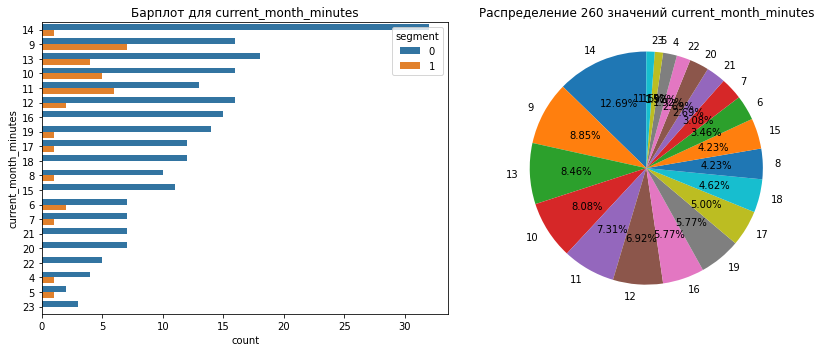

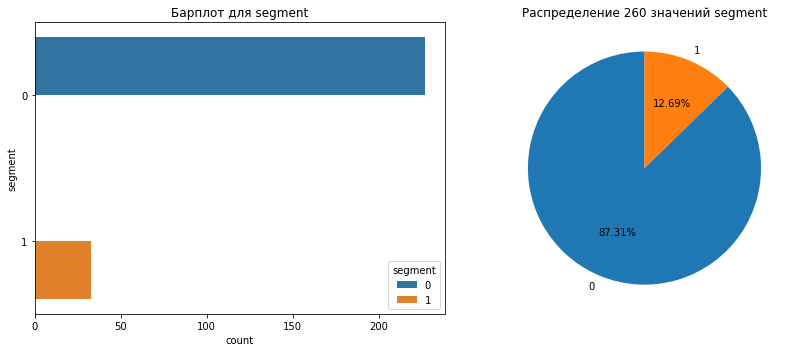

In [97]:
plotting_stat_graphs(
    market_test.select_dtypes(include=['number']),
    'segment'
)

В наш сегмент попали только 35 покупателя, поэтому анализ усложняется. Из наиболее заметного:

* В среднем смотрят меньше страниц и категорий
* Имеют большое количество неоплаченных товаров
* Количество минут, проведенных на сервисе, ниже среднего
* При этом прибыль от этих людей распределена, как и у всех покупателей 

# Общий вывод

**Задача**

В данной работе проводился анализ покупателей магазина различных товаров "В один клик". На основе имеющихся данных прогнозировалось снижение покупательской активности. По результатам прогноза рассматривался сегмент покупателей, часто пользующихся скидками.

**Входные данные:**
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.
* минут — значение времени, проведённого на сайте, в минутах.
* Прибыль — значение прибыли.

Типизация полученных данных корректна, пропусков в данных нет, явные дубликаты отсутствуют. В столбце `service_type` таблицы `market_file` была ошибка в записи: 'стандартт' заменили на 'стандарт' 

**Анализ данных:**
* marketing_activity_6_month
Наблюдения распределены куполообразно с пиком в 4 коммуникациях. Наблюдаются дискретные пики, что можно связать, например, с общими рассылками от магазина, приходящими всем согласившимся клиентам

* marketing_activity_current_month
Есть только три пика - 3, 4 и 5 коммуникаций. Это также может быть показателем общих рассылок

* duration
Имеем также куполообразное распределение с пиком на 600 днях. Каких-то закономерностей не наблюдается. Можно только заметить, что в данных нет новых пользователей, зарегистрировавшихся мене 110 дней назад

* promo_purchases
Наблюдаеются два пика - около 20% и около 90%. Левый пик может соответствовать обычным покупателям, а правый - тем, кто специально приходит в магазин за акциями, возможно, их привлекают специальные предложения

* avg_categories_viewed_per_visit
В среднем покупатели просматривают от 1 до 6 категорий за один визит. Особых закономерностей не наблюдается

* unpaid_products_qty_quarter
Смещенный влево пик показывает, что в корзине за 3 месяца лежат до 10 товаров. При этом чаще всего 1 или 2. Есть выбросы с 9 и 10 товарами

* service_error
Куполообразное распределение около 4

* pages_per_visit
Распределение похоже на unpaid_products_qty_quarter. За визит покупатели посещают до 20 страниц. При этом выбросы не найдены, то есть тех, кто смотрит много страниц не так мало

* customer_activity
У 62% активность осталась на прежнем уровне, у остальных - снизилась

* service_type
Премиум сервиса более чем в два раза меньше, чем стандарта

* allow_notifications
74% пользователей позволяют делать рассылку. То есть такой метод привлечения покупателей может быть действенным

* popular_category
Есть 6 категорий, наиболее представленными являются детские товары. Сильного перекоса в распределении нет

Здесь можно заметить определенные закономерности у покупателей со снизившейся активностью: 

* Чаще пользуются акциями
* Меньше категорий и страниц смотрят за раз
* Имеют больше вещей в корзине

Можно предположить, что часть из них изначально являются редкими пользователями сервиса, с чем отчасти и связано снижение

Все числовые признаки имеют распределение, отличное от нормального

Были отсеяны 3 человека, кто не имел покупок в последние три месяца

**Корреляция**

**Матрица корреляции Спирмена** (числовые переменные)
- **Заметные корреляции**:
  - `previous_month_revenue` и `current_month_revenue`: **0.88** — очень сильная положительная связь. Это указывает на потенциальную мультиколлинеарность, так как эти переменные могут дублировать информацию о доходах. Чуть менее выражена связь с `pre_previous_month_revenue` (**0.31**)
  - `previous_month_minutes`, `current_month_minutes`: **0.36** - слабая связь.
  - `pages_per_visit` и `previous_month_minutes`: **0.45** — умеренная положительная связь.
  - `pre_previous_month_revenue` и `previous_month_revenue`: **0.31** — слабая связь, но стоит учитывать в совокупности с другими корреляциями.

- **Заметные отрицательные корреляции**:
  - `marketing_activity_6_months` и `promo_purchases`: **-0.28** — слабая отрицательная связь.
  - `promo_purchases` и `pages_per_visit`: **-0.37** — умеренная отрицательная связь.

**Матрица корреляции $\phi_k$** (категориальные и числовые переменные)
- **Заметные корреляции**:
  - `customer_activity` и `pages_per_visit`: **0.75** — очень сильная связь. 
  - `customer_activity` и `previous_month_minutes`: **0.69** — сильная связь.
  - `customer_activity` и `marketing_activity_6_months`: **-0.55** — умеренная отрицательная связь.
  - `pages_per_visit` и `previous_month_minutes`: **0.48** — умеренная связь.
  - `service_type` и `duration`: **0.40** — умеренная связь.
  - `allow_notifications` и `duration`: **0.25** — слабая связь.

Оценка с помощью VIF показала все коэффициенты ниже 5, что говорит о низкой коллинеарности между численными данными. Таким образом, проблем, связанных с мультиколлинеарностью возникнуть не должно

**Поиск лучшей модели:**

В поставленной задаче нужно точно выделить покупателей, у которых активность снизится. В дальнейшем для таких клиентов будут разрабатываться специальные предложения. Для того, чтобы не потерять клиентов и вовремя их привлечь, нужно повышать метрику recall. При этом, если делать особые предложения тем, кто на самом деле не уходит, магазин также может начать терять не клиентов, но уже деньги. 

Для выбора лучшей модели среди KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC() использовали GridSearchCV с метрикой f1_score. По результатам подбора наилучшей оказалась модель SVC. Вторым шагом GridSearchCV использовался для подбора лучших параметров этой модели с оценкой roc_auc_score. 

Получившиеся оптимальные параметры оказались следующими:
* Обработка количественных признаков: `StandardScaler()`
* Лучшая модель: `SVC(C=np.float64(1.0), random_state=42, gamma='scale')`

На тестовых данных она показала следующие метрики:
* f1-мера: 0.876
* roc_auc_score: 0.919

## Промежуточные выводы

На основе значений Шепли для нашей модели и данных можно заключить, что наиболее значимыми являются столбцы: 
* 'num__pages_per_visit',
* 'num__previous_month_minutes',
* 'num__current_month_minutes',
* 'num__promo_purchases',
* 'num__avg_categories_viewed_per_visit',
* 'num__unpaid_products_qty_quarter',
* 'num__marketing_activity_6_months',
* 'num__pre_previous_month_revenue',
* 'num__previous_month_revenue'

Со средними абсолютными значениями Шепли от 0.05 до 0.2. Все они прямо связаны с активностью покупателя в сревисе, а значит и с его покупательской активностью. То есть результат выглядит рационально

По значениям beeswarm видны следующие закономерности:
* Чем меньше страниц смотрит покупатель за висит, тем больше модель склоняется к тому, что он уйдет
* Аналогично с временем в сервисе
* Если покупатель все больше покупает по скидке, тем менее устойчивым видит его модель
* Аналогично с неоплаченными вещами

Наименее значимыми (со значением Шепли меньше 0.025) значения являются:
* 'ohe__popular_category_Мелкая бытовая техника и электроника',
 * 'ohe__popular_category_Техника для красоты и здоровья',
 * 'ord__service_type',
 * 'ohe__popular_category_Кухонная посуда',
 * 'ohe__popular_category_Товары для детей',
 * 'ohe__popular_category_Косметика и аксесуары',
 * 'ord__allow_notifications',
 * 'num__current_month_revenue'

Видно, что они по большей части связаны с популярными категориями и выручкой, что уже не так сильно в действительности связано с клиентами, использующими магазин "разных товаров" - для улучшения модели попробуем убрать эти значения из датасета

**Анализ сегмента:**

Используя предсказание модели был отобран один сегмент покупателей: Те, кто имеют шанс снижения активности выше 50% и покупающие по акциям более 50% товаров. 

Такие пользователи с отрывом предпочитают товары для дома и детские товары - масштабные жизненные изменения заставляют больше обращать внимение на скидки. 

Также по анализу их привычек видно, что такие покупатели проводят мало времени в сервисе, смотрят мало страниц и категорий - они не заинтересованы в листании каталогов, берут по акциям что-то конкретное. 

Таким образом для данного сегмента я бы предложил делать более таргетированную рекламу с использованием товаров основных категорий и с возможностью быстро открыть подборку товаров в одном месте, уменьшая взаимодействие с системой.